In [74]:
import pandas as pd

shasta_final = pd.read_csv('shasta_final.csv', encoding='utf-8')
mellat_final = pd.read_csv('mellat_final.csv', encoding='utf-8')
foolad_final = pd.read_csv('foolad_final.csv', encoding='utf-8')

final_df = pd.concat([shasta_final, mellat_final, foolad_final])

In [ ]:
!pip install -q langchain
!pip install -q langchain-community
!pip install -q ollama

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.5/2.5 MB 37.6 MB/s eta 0:00:00a 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [83]:
import json
from datetime import datetime
from dateutil import parser
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

## read the comments files

In [ ]:
import json

with open('/content/drive/MyDrive/spmp/shasta_tweets.json', 'r', encoding = 'utf-8-sig') as f1:
  shasta = json.load(f1)

with open('/content/drive/MyDrive/spmp/mellat_tweets.json', 'r', encoding = 'utf-8-sig') as f2:
  mellat = json.load(f2)

with open('/content/drive/MyDrive/spmp/foolad_tweets.json', 'r', encoding = 'utf-8-sig') as f3:
  foolad = json.load(f3)

## pick data in desired time period

In [ ]:
# Define the date range

def filter_dates(data, start = "2025-01-21T00:00:00+03:30", end = "2025-07-13T00:00:00+03:30"):
  start = parser.parse(start)
  end = parser.parse(end)

  # Filter records within the range
  filtered = [
      item for item in data
      if start <= parser.parse(item["creation_date_time"]) <= end
  ]
  return filtered

shasta_filtered = filter_dates(shasta)
mellat_filtered = filter_dates(mellat)
foolad_filtered = filter_dates(foolad)

In [ ]:
print(f'shasta comments: {len(shasta_filtered)}')
print(f'mellat comments: {len(mellat_filtered)}')
print(f'foolad comments: {len(foolad_filtered)}')

shasta comments: 4090
mellat comments: 19200
foolad comments: 11676


In [ ]:
!curl https://ollama.ai/install.sh | sh
!ollama serve > rocama.log 2>&1 &
!ollama pull aya-expanse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13281    0 13281    0     0  36130      0 --:--:-- --:--:-- --:--:-- 36188
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.



## promp template

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama

tagging_prompt = ChatPromptTemplate.from_template(
  """ÿ®Ÿá ÿπŸÜŸàÿßŸÜ €å⁄© ÿ™ÿ≠ŸÑ€åŸÑ⁄Øÿ± ÿÆÿ®ÿ±Ÿáÿå ÿßÿ≠ÿ≥ÿßÿ≥ÿßÿ™ ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿ™Ÿà€å€åÿ™‚ÄåŸáÿß€å ŸÅÿßÿ±ÿ≥€å ÿØÿ±ÿ®ÿßÿ±Ÿá ÿ®ÿßÿ≤ÿßÿ± ÿ®Ÿàÿ±ÿ≥ ÿß€åÿ±ÿßŸÜ ÿ±ÿß ÿ∑ÿ®ŸÇŸá‚Äåÿ®ŸÜÿØ€å ⁄©ŸÜ. ÿ®ÿ±ÿß€å ÿ™Ÿàÿµ€åŸÅ ÿßÿ≠ÿ≥ÿßÿ≥ÿßÿ™ ŸÖŸàÿ¨ŸàÿØ
  ÿØÿ± ÿ™Ÿà€å€åÿ™ÿå ÿ™ŸÜŸáÿß ÿßÿ≤ €å⁄© ⁄©ŸÑŸÖŸá ÿßÿ≥ÿ™ŸÅÿßÿØŸá ⁄©ŸÜ Ÿà ÿßÿ≤ ÿßÿ±ÿßÿ¶Ÿá ÿ™Ÿàÿ∂€åÿ≠ÿßÿ™ ÿßÿ∂ÿßŸÅ€å ÿÆŸàÿØÿØÿßÿ±€å ⁄©ŸÜ.
⁄©ŸÑÿßÿ≥‚ÄåŸáÿß: ŸÖÿ´ÿ®ÿ™ÿå ŸÖŸÜŸÅ€åÿå ÿÆŸÜÿ´€å

ŸÖÿ´ÿßŸÑ‚ÄåŸáÿß:
€±. ÿ™Ÿà€å€åÿ™: "ÿ≥ŸáÿßŸÖ ŸÅŸàŸÑÿßÿØ ÿßŸÖÿ±Ÿàÿ≤ ÿπŸÖŸÑ⁄©ÿ±ÿØ ÿπÿßŸÑ€å ÿØÿßÿ¥ÿ™ Ÿà ÿ±ÿ¥ÿØ ÿÆŸàÿ®€å ⁄©ÿ±ÿØ"
ÿßÿ≠ÿ≥ÿßÿ≥: ŸÖÿ´ÿ®ÿ™

€≤. ÿ™Ÿà€å€åÿ™: "ŸÜ⁄Øÿ±ÿßŸÜ ÿ¢€åŸÜÿØŸá ÿ≥ŸáÿßŸÖ ÿÆŸàÿØÿ±Ÿà Ÿáÿ≥ÿ™ŸÖÿå ÿ®Ÿá ŸÜÿ∏ÿ± ŸÖ€å‚Äåÿ±ÿ≥ÿØ ÿßŸÅÿ™ ÿßÿØÿßŸÖŸá ÿØÿßÿ± ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ"
ÿßÿ≠ÿ≥ÿßÿ≥: ŸÖŸÜŸÅ€å

€≥. ÿ™Ÿà€å€åÿ™: "ÿ¥ÿ±⁄©ÿ™ ŸÖÿÆÿßÿ®ÿ±ÿßÿ™ ÿßŸÖÿ±Ÿàÿ≤ ⁄Øÿ≤ÿßÿ±ÿ¥ ŸÖÿßŸÑ€å ÿÆŸàÿØ ÿ±ÿß ŸÖŸÜÿ™ÿ¥ÿ± ⁄©ÿ±ÿØ"
ÿßÿ≠ÿ≥ÿßÿ≥: ÿÆŸÜÿ´€å

ÿ™Ÿà€å€åÿ™ ÿ¨ÿØ€åÿØ: "{tweet}"
ÿßÿ≠ÿ≥ÿßÿ≥:"""
)



local_model = 'aya-expanse'
llm = ChatOllama(model = local_model)

/tmp/ipython-input-8-228756727.py:26: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model = local_model)


In [ ]:
from tqdm import tqdm

def labeling(data, stock_name):
  for each in tqdm(data):
    inp = each['body']
    prompt = tagging_prompt.invoke({"tweet": inp})
    answer = llm.invoke(prompt)
    each['sentiment_label'] = answer.content

  file_path = f'/content/drive/MyDrive/spmp/{stock_name}_labeled.json'
  with open(file_path, 'w', encoding='utf-8-sig') as f:
    json.dump(data, f, indent=2, ensure_ascii=False)
  print(f'{stock_name}_labeled.json saved successfully')
  return f'{stock_name}_labeled.json saved successfully'

labeling(shasta_filtered, 'shasta')
labeling(mellat_filtered, 'mellat')
labeling(foolad_filtered, 'foolad')

NameError: name 'mellat_filtered' is not defined

In [ ]:
import json

with open('/content/drive/MyDrive/spmp/shasta_labeled.json', 'r', encoding = 'utf-8-sig') as f1:
  shasta = json.load(f1)

with open('/content/drive/MyDrive/spmp/mellat_labeled.json', 'r', encoding = 'utf-8-sig') as f2:
  mellat = json.load(f2)

with open('/content/drive/MyDrive/spmp/foolad_labeled.json', 'r', encoding = 'utf-8-sig') as f3:
  foolad = json.load(f3)

In [ ]:
import pandas as pd

# Convert to DataFrame
def convert_to_df(comments_data):
  df_comments = pd.DataFrame([{
    'id': x['id'],
    'text': x['body'],
    'datetime': x['creation_date_time'],
    'symbol': x['entity_info']['info']['english_trade_symbol'],
    'sentiment': x['sentiment_label'],
    'upvotes': x['upvote_count'],
    'downvotes': x['downvote_count']
  } for x in comments_data])

  # Convert to datetime (Iran timezone)
  df_comments['datetime'] = pd.to_datetime(df_comments['datetime']).dt.tz_convert('Asia/Tehran')
  return df_comments

shasta_comment = convert_to_df(shasta)
mellat_comment = convert_to_df(mellat)
foolad_comment = convert_to_df(foolad)

In [ ]:
def assign_trading_date(dt):
    """Assign comments to trading date (8AM-8AM window)"""
    dt = dt.tz_localize(None)  # Remove timezone for comparison
    if dt.hour >= 8:
        return dt.date()
    else:
        return (dt - timedelta(days=1)).date()

shasta_comment['trading_date'] = shasta_comment['datetime'].apply(assign_trading_date)
mellat_comment['trading_date'] = mellat_comment['datetime'].apply(assign_trading_date)
foolad_comment['trading_date'] = foolad_comment['datetime'].apply(assign_trading_date)

In [ ]:
# Map Persian sentiment to English
def map_sentiment(df_comments):
    sentiment_map = {'ŸÖŸÜŸÅ€å': 'negative', 'ŸÖÿ´ÿ®ÿ™': 'positive', 'ÿÆŸÜÿ´€å': 'neutral'}
    df_comments['sentiment'] = df_comments['sentiment'].map(sentiment_map)
    return df_comments


shasta_comment = map_sentiment(shasta_comment)
mellat_comment = map_sentiment(mellat_comment)
foolad_comment = map_sentiment(foolad_comment)



In [ ]:
shasta_comment.head()

id                                               text  \
0  16783810                          ŸÅÿ±ÿØÿß ŸáŸÖ ÿµŸÅ ÿÆÿ±€åÿØ ÿÆŸàÿßŸáÿØ ÿ®ŸàÿØ   
1  16782666  ÿßŸÑŸàÿπÿØŸá ŸàŸÅÿß ÿ®ÿßŸÑÿßÿÆÿ±Ÿá ÿß€åŸÜ ÿ≥ŸáŸÖ ⁄©ÿßÿ±⁄Øÿ±€å ÿ®Ÿá ÿßÿπÿØÿßÿØ 116...   
2  16780493  ÿ™€åÿ™ÿ± ÿ≥ÿß€åÿ™ ÿ¨ŸáÿßŸÜ€å ŸÜŸÅÿ™\n⁄©ÿßŸáÿ¥ ŸÇ€åŸÖÿ™ ŸÜŸÅÿ™ ÿ®ÿß ÿßÿ≤ ÿ≥ÿ±⁄Ø€åÿ±...   
3  16780326  ÿ≠ŸÇŸàŸÇ€å ŸÅŸÇÿ∑ ŸÖ€åŸÅÿ±ŸàÿÆÿ™ ŸÅÿ±Ÿàÿ¥ŸÜÿØŸá ŸÜÿØÿßÿ¥ÿ™ ÿå ÿ≥ŸáŸÖ ÿßÿ±ÿ≤ŸÜÿØŸá ÿß...   
4  16779507                        ÿ≥ŸáŸÖ ÿÆŸàÿ®€å Ÿáÿ≥ÿ™\n\nÿ≠ÿ≥ÿßÿ®€å ÿÆÿ±€åÿØŸÜ   

                   datetime symbol sentiment  upvotes  downvotes trading_date  
0 2025-07-12 21:39:12+03:30  TAMN1  positive        4          2   2025-07-12  
1 2025-07-12 17:31:43+03:30  TAMN1  positive        2          4   2025-07-12  
2 2025-07-12 12:50:54+03:30  TAMN1  negative        3          3   2025-07-12  
3 2025-07-12 12:40:13+03:30  TAMN1  positive        2          2   2025-07-12  
4 2025-07-12 12:04:45+03:30  TAMN1  positive        3          1   2025-07-12

/tmp/ipython-input-9-2436982616.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


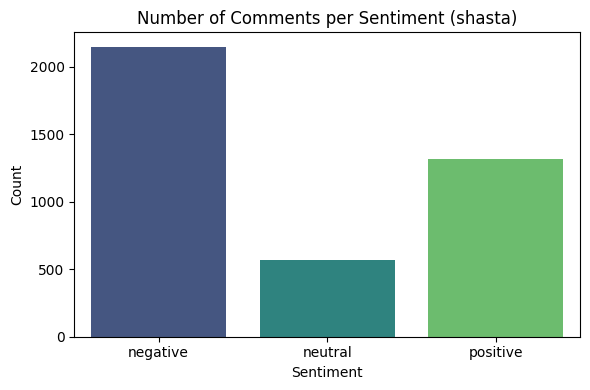

/tmp/ipython-input-9-2436982616.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


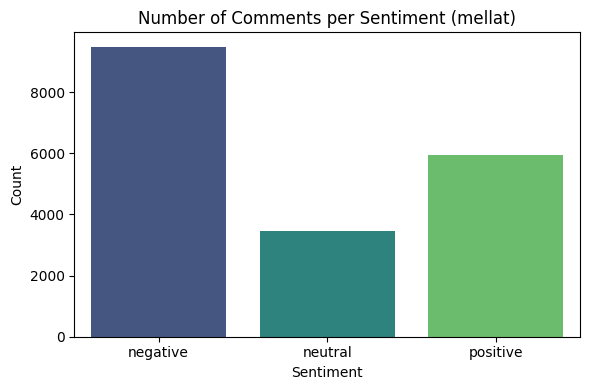

/tmp/ipython-input-9-2436982616.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


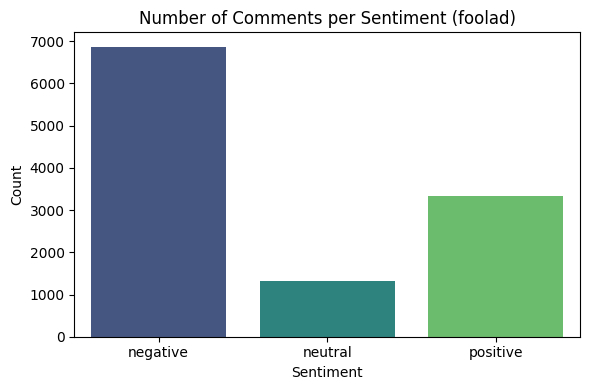

In [ ]:
def plotting(df_comment, stock):
  # Count each sentiment
  sentiment_counts = df_comment["sentiment"].value_counts().reindex(["negative", "neutral", "positive"], fill_value=0)

  # Plot
  plt.figure(figsize=(6, 4))
  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

  plt.title(f"Number of Comments per Sentiment ({stock})")
  plt.xlabel("Sentiment")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()

plotting(shasta_comment, 'shasta')
plotting(mellat_comment, 'mellat')
plotting(foolad_comment, 'foolad')

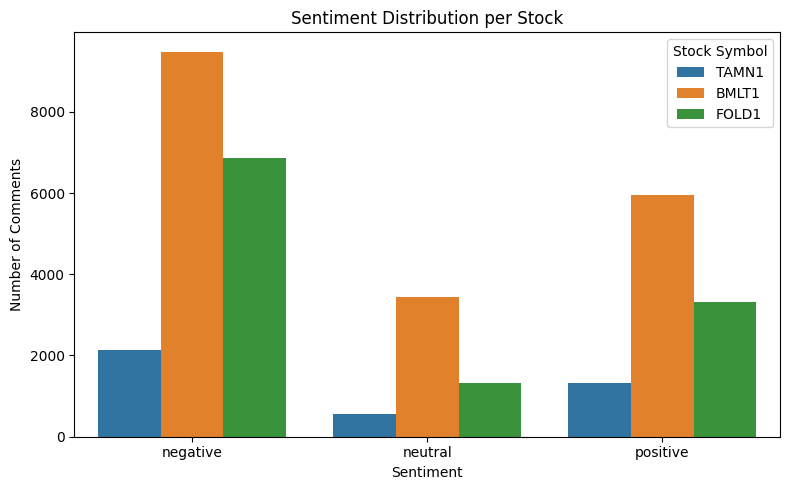

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Combine all DataFrames
df_all = pd.concat([shasta_comment, mellat_comment, foolad_comment], ignore_index=True)

# Count of sentiments per stock
sentiment_counts = df_all.groupby(['sentiment', 'symbol']).size().reset_index(name='count')

# Optional: ensure full matrix (all sentiments for all symbols)
sentiments = ['negative', 'neutral', 'positive']
symbols = df_all['symbol'].unique()
full_index = pd.MultiIndex.from_product([sentiments, symbols], names=['sentiment', 'symbol'])
sentiment_counts = sentiment_counts.set_index(['sentiment', 'symbol']).reindex(full_index, fill_value=0).reset_index()

# Plot: grouped bar chart (sentiment on x-axis, one bar per stock)
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_counts, x='sentiment', y='count', hue='symbol', palette='tab10')

plt.title("Sentiment Distribution per Stock")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.legend(title="Stock Symbol")
plt.tight_layout()
plt.show()


/tmp/ipython-input-11-2298929470.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-2298929470.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("sentiment_plot.svg", format='svg')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


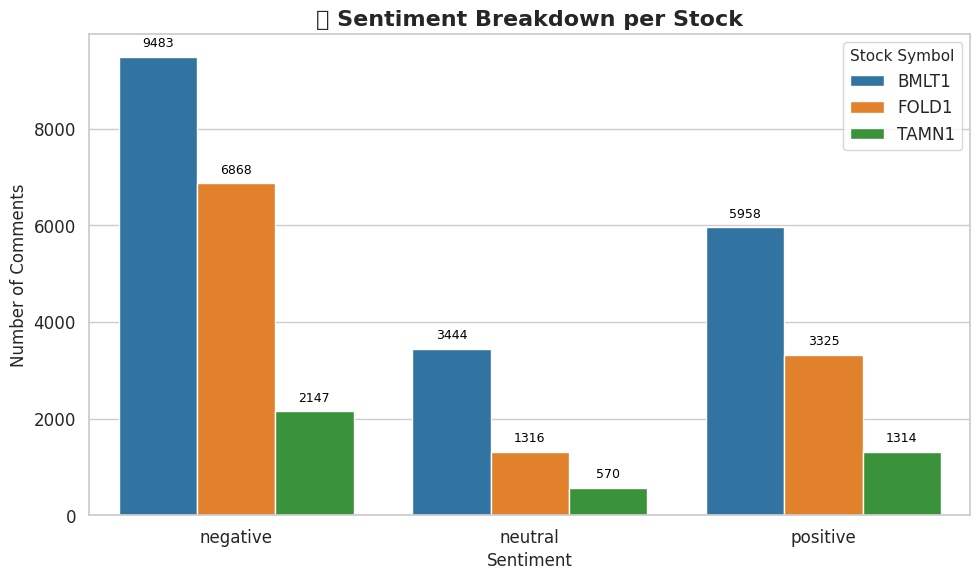

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all DataFrames
df_all = pd.concat([shasta_comment, mellat_comment, foolad_comment], ignore_index=True)

# Ensure we have the correct columns
assert 'sentiment' in df_all.columns
assert 'symbol' in df_all.columns

# Define expected sentiment order
sentiments = ['negative', 'neutral', 'positive']
symbols = df_all['symbol'].unique()

# Group and count
sentiment_counts = (
    df_all.groupby(['sentiment', 'symbol'])
    .size()
    .reset_index(name='count')
)

# Ensure all sentiment-symbol combinations are present
sentiment_counts = sentiment_counts.pivot(index='sentiment', columns='symbol', values='count').fillna(0)
sentiment_counts = sentiment_counts.reindex(sentiments)  # Ensure sentiment order
sentiment_counts = sentiment_counts.reset_index().melt(id_vars='sentiment', var_name='symbol', value_name='count')

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid', font_scale=1.1)

palette = sns.color_palette('tab10', n_colors=len(symbols))

ax = sns.barplot(
    data=sentiment_counts,
    x='sentiment',
    y='count',
    hue='symbol',
    palette=palette
)

# Annotate bar heights
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Titles and formatting
plt.title("üìä Sentiment Breakdown per Stock", fontsize=16, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.legend(title="Stock Symbol", title_fontsize=11)
plt.tight_layout()
plt.savefig("sentiment_plot.svg", format='svg')
plt.show()


In [ ]:
def sentiment_analysis(df_comments):
  # Calculate sentiment score
  #Weighted sentiment score (upvotes - downvotes)
  df_comments['sentiment_score'] = np.where(
      df_comments['sentiment'] == 'negative', -1 * (df_comments['upvotes'] + 1),
      np.where(df_comments['sentiment'] == 'positive', df_comments['upvotes'] + 1, 0)
  )

  # Daily aggregation
  daily_sentiment = df_comments.groupby(['trading_date', 'symbol']).agg(
      num_neg=('sentiment', lambda x: (x == 'negative').sum()),
      num_pos=('sentiment', lambda x: (x == 'positive').sum()),
      total=('sentiment', 'count'),
      weighted_score=('sentiment_score', 'sum')
  ).reset_index()

  # Calculate EIst (negative sentiment %)
  daily_sentiment['EIst'] = (daily_sentiment['num_neg'] / daily_sentiment['total']) * 100
  daily_sentiment['trading_date'] = pd.to_datetime(daily_sentiment['trading_date'])
  return daily_sentiment

shasta_sentiment = sentiment_analysis(shasta_comment)
mellat_sentiment = sentiment_analysis(mellat_comment)
foolad_sentiment = sentiment_analysis(foolad_comment)

In [ ]:
shasta_sentiment.head()

trading_date symbol  num_neg  num_pos  total  weighted_score       EIst
0   2025-01-20  TAMN1        0        2      2              19   0.000000
1   2025-01-21  TAMN1        9        8     23              11  39.130435
2   2025-01-22  TAMN1        9        5     22             -25  40.909091
3   2025-01-23  TAMN1       10        6     20             -38  50.000000
4   2025-01-24  TAMN1        7        2     18             -21  38.888889

price dataset

In [ ]:
foolad_prices = pd.read_csv(
        '/content/drive/MyDrive/spmp/foolad.csv',
        parse_dates=['<DTYYYYMMDD>'],  # Ensure Date column is parsed as datetime
        encoding='utf-8'       # Handle Persian characters if any
)

shasta_prices = pd.read_csv(
        '/content/drive/MyDrive/spmp/shasta.csv',
        parse_dates=['<DTYYYYMMDD>'],
        encoding='utf-8'
)

mellat_prices = pd.read_csv(
        '/content/drive/MyDrive/spmp/mellat.csv',
        parse_dates=['<DTYYYYMMDD>'],
        encoding='utf-8'
)

In [ ]:
foolad_prices.head()

<TICKER> <DTYYYYMMDD>  <FIRST>  <HIGH>   <LOW>  <CLOSE>  \
0  S*Mobarakeh.Steel   2025-07-12   3086.0  3086.0  3047.0   3081.0   
1  S*Mobarakeh.Steel   2025-07-09   2958.0  3048.0  2948.0   2997.0   
2  S*Mobarakeh.Steel   2025-07-08   3099.0  3099.0  3033.0   3035.0   
3  S*Mobarakeh.Steel   2025-07-07   3162.0  3162.0  3059.0   3126.0   
4  S*Mobarakeh.Steel   2025-07-02   3007.0  3164.0  3007.0   3070.0   

         <VALUE>      <VOL>  <OPENINT> <PER>  <OPEN>  <LAST>  
0  1325277087007  430154343       7749     D  2997.0  3086.0  
1  1464792205107  488692789       9650     D  3035.0  3030.0  
2   996665279392  328355325       5071     D  3126.0  3033.0  
3  1724057889809  551505681      12305     D  3070.0  3070.0  
4  2770870206978  902488855      17386     D  3100.0  3133.0

In [ ]:
foolad_prices['symbol'] = "FOLD1"
shasta_prices['symbol'] = "TAMN1"
mellat_prices['symbol'] = "BMLT1"

In [ ]:
def merge(df_prices, daily_sentiment):
  # Merge sentiment with prices
  df_merged = pd.merge(
      df_prices,
      daily_sentiment,
      left_on=['<DTYYYYMMDD>', 'symbol'],
      right_on=['trading_date', 'symbol'],
      how='left'
  )
  return df_merged

shasta_merged = merge(shasta_prices, shasta_sentiment)
mellat_merged = merge(mellat_prices, mellat_sentiment)
foolad_merged = merge(foolad_prices, foolad_sentiment)

In [ ]:
shasta_merged.head()

<TICKER> <DTYYYYMMDD>  <FIRST>  <HIGH>   <LOW>  <CLOSE>  \
0  Social Sec Inv   2025-07-12   1217.0  1247.0  1217.0   1242.0   
1  Social Sec Inv   2025-07-09   1197.0  1233.0  1197.0   1211.0   
2  Social Sec Inv   2025-07-08   1277.0  1277.0  1233.0   1234.0   
3  Social Sec Inv   2025-07-07   1275.0  1300.0  1252.0   1271.0   
4  Social Sec Inv   2025-07-02   1255.0  1301.0  1255.0   1263.0   

        <VALUE>       <VOL>  <OPENINT> <PER>  <OPEN>  <LAST> symbol  \
0  4.581689e+11   368907450       4175     D  1211.0  1240.0  TAMN1   
1  6.284851e+11   519183466       5384     D  1234.0  1229.0  TAMN1   
2  4.910177e+11   397841371       3558     D  1271.0  1233.0  TAMN1   
3  5.773903e+11   454130661       5594     D  1263.0  1254.0  TAMN1   
4  4.579868e+12  3627346966      27110     D  1293.0  1282.0  TAMN1   

  trading_date  num_neg  num_pos  total  weighted_score       EIst  
0   2025-07-12      4.0      9.0   14.0            17.0  28.571429  
1   2025-07-09     11.0      2.0   14.0           -41.0  78.571429  
2   2025-07-08     17.0      5.0   27.0           -84.0  62.962963  
3   2025-07-07     11.0      4.0   15.0           -23.0  73.333333  
4   2025-07-02     10.0      3.0   15.0           -24.0  66.666667

In [ ]:
cols_to_rename = {
    '<TICKER>': 'ticker',
    '<DTYYYYMMDD>': 'date',
    '<FIRST>': 'first',
    '<HIGH>': 'high',
    '<LOW>': 'low',
    '<CLOSE>': 'close',
    '<VALUE>': 'value',
    '<VOL>': 'volume',
    '<OPENINT>': 'openint',
    '<PER>': 'period',
    '<OPEN>': 'open',
    '<LAST>': 'last'
}

shasta_merged = shasta_merged.rename(columns=cols_to_rename)
mellat_merged = mellat_merged.rename(columns=cols_to_rename)
foolad_merged = foolad_merged.rename(columns=cols_to_rename)


In [ ]:
import numpy as np
import pandas as pd

def calculate_metrics(df_merged, total_shares, free_float, floor_liquidity, EPS):
    final_df = df_merged.sort_values(['symbol', 'date'])

    # total_shares = 1.5e9
    # free_float = 0.36
    # floor_liquidity = 39.088e6
    # EPS = 591

    # VCP and VOP direction
    final_df['VCP_dir'] = np.where(
        final_df.groupby('symbol')['close'].diff() >= 0, 'up', 'down')

    final_df['VOP_dir'] = np.where(
        final_df.groupby('symbol')['open'].diff() >= 0, 'up', 'down')

    # Daily price change
    final_df['daily_change'] = final_df['close'] - final_df['open']

    # Turnover Rate
    final_df['TR'] = final_df['volume'] / total_shares
    final_df['TR_Class'] = np.where(final_df['TR'] >= 0.3, 'High', 'Low')

    final_df['TR_Simplified'] = final_df['volume'] / final_df['volume'].rolling(30).mean()

    # PE Ratio
    final_df['PE'] = final_df['close'] / EPS
    final_df['VPE_dir'] = np.where(final_df.groupby('symbol')['PE'].diff() >= 0, 'up', 'down')

    # PB Ratio using sector average (proxy)
    sector_avg_pb = 1.79
    final_df['PB'] = final_df['close'] / (final_df['close'].mean() / sector_avg_pb)
    final_df['VPB_dir'] = np.where(final_df.groupby('symbol')['PB'].diff() >= 0, 'up', 'down')

    # Stable volume
    final_df['Is_Stable'] = final_df['volume'] >= floor_liquidity

    # Free Float Turnover
    final_df['FF_TR'] = final_df['volume'] / (total_shares * free_float)
    final_df['FF_TR_Class'] = np.where(final_df['FF_TR'] >= 0.3, 'High', 'Low')

    # Label: will price go up tomorrow?
    final_df['label'] = np.where(
        final_df.groupby('symbol')['close'].shift(-1) > final_df['close'],
        1, 0
    )

    # Drop rows missing dates
    df_cleaned = final_df.dropna(subset=['date'])

    # EIst classification
    conditions = [
        (df_cleaned['EIst'] <= 50),
        (df_cleaned['EIst'] > 50) & (df_cleaned['EIst'] <= 60),
        (df_cleaned['EIst'] > 60)
    ]
    choices = ['non_negative', 'weak_negative', 'strong_negative']

    df_cleaned['EIst_class'] = np.select(conditions, choices, default='neutral')

    return df_cleaned


shasta_final = calculate_metrics(shasta_merged, total_shares = 1.636013e12, free_float = 0.13, floor_liquidity=9.9174e7, EPS = 161)
mellat_final = calculate_metrics(mellat_merged, total_shares = 1.21e9, free_float = 0.38, floor_liquidity=5.4176e7, EPS = 1669)
foolad_final = calculate_metrics(foolad_merged, total_shares = 1.5e9, free_float = 0.36, floor_liquidity=40.027e6, EPS = 625)

In [ ]:
shasta_final.columns

Index(['ticker', 'date', 'first', 'high', 'low', 'close', 'value', 'volume',
       'openint', 'period', 'open', 'last', 'symbol', 'trading_date',
       'num_neg', 'num_pos', 'total', 'weighted_score', 'EIst', 'VCP_dir',
       'VOP_dir', 'daily_change', 'TR', 'TR_Class', 'TR_Simplified', 'PE',
       'VPE_dir', 'PB', 'VPB_dir', 'Is_Stable', 'FF_TR', 'FF_TR_Class',
       'label', 'EIst_class'],
      dtype='object')

In [ ]:
shasta_final.to_csv('/content/drive/MyDrive/spmp/shasta_final.csv', index=False, encoding='utf-8-sig')
mellat_final.to_csv('/content/drive/MyDrive/spmp/mellat_final.csv', index=False, encoding='utf-8-sig')
foolad_final.to_csv('/content/drive/MyDrive/spmp/foolad_final.csv', index=False, encoding='utf-8-sig')

In [ ]:
shasta_final = pd.read_csv('/content/drive/MyDrive/spmp/shasta_final.csv', encoding='utf-8')
mellat_final = pd.read_csv('/content/drive/MyDrive/spmp/mellat_final.csv', encoding='utf-8')
foolad_final = pd.read_csv('/content/drive/MyDrive/spmp/foolad_final.csv', encoding='utf-8')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


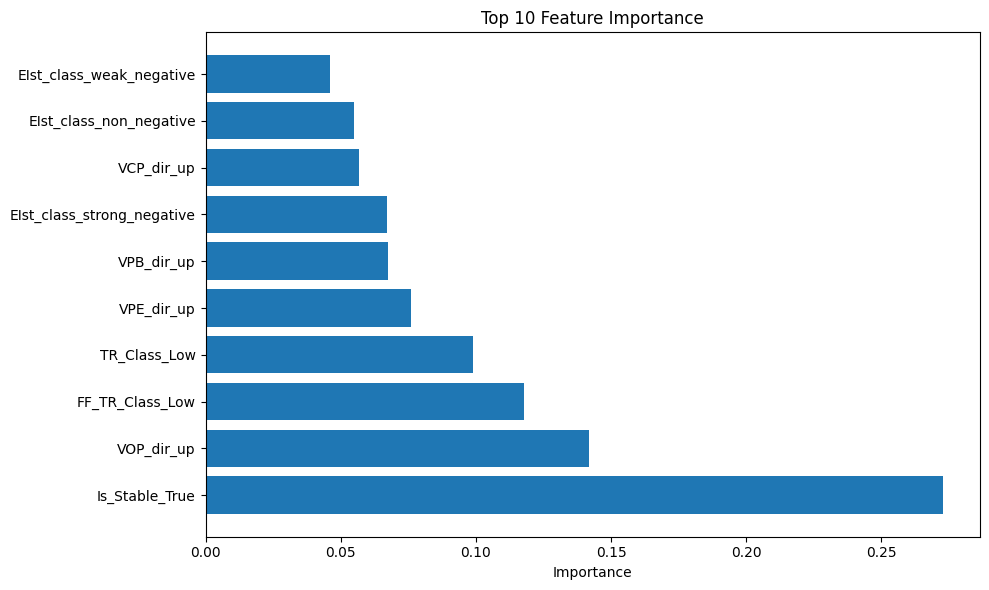

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

Sample Decision Rules:
 |--- VOP_dir_up <= 0.50
|   |--- VPB_dir_up <= 0.50
|   |   |--- EIst_class_non_negative <= 0.50
|   |   |   |--- TR_Class_Low <= 0.50
|   |   |   |   |--- EIst_class_weak_negative <= 0.50
|   |   |   |   |   |--- EIst_class_strong_negative <= 0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- EIst_class_strong_negative >  0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- EIst_class_weak_negative >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- TR_Class_Low >  0.50
|   |   |   |   |--- Is_Stable_True <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Is_Stable_True >  0.50
|   |   |   |   |   |--- FF_TR_Class_Low <= 0.50
|   |   |   |   |   |   |--- EIst_class_strong_negative <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import export_text
import matplotlib.pyplot as plt

def optimized_rf_training(df, target_col="label", random_state=42, n_iter=50):
    """
    Optimized Random Forest training with categorical features.

    Args:
        df: Input DataFrame with categorical features
        target_col: Name of target column (default: "label")
        random_state: Random seed (default: 42)
        n_iter: Number of iterations for RandomizedSearchCV (default: 50)

    Returns:
        Dictionary containing:
        - best_params: Optimal parameters
        - feature_importance: DataFrame of feature importances
        - sample_tree_rules: Decision rules from first tree
        - encoder: Fitted OneHotEncoder
    """
    # Step 1: Preprocess categorical features
    categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']

    X = df[categorical_cols]
    y = df[target_col]

    encoder = OneHotEncoder(drop="first", sparse_output=False)
    X_encoded = encoder.fit_transform(X)
    feature_names = encoder.get_feature_names_out(categorical_cols)

    # Step 2: Optimized hyperparameter search
    param_dist = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.8],
        "class_weight": [None, "balanced"]
    }

    tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for efficiency
    rf = RandomForestClassifier(random_state=random_state)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )

    search.fit(X_encoded, y)

    # Step 3: Extract results
    best_rf = search.best_estimator_

    # Feature importance
    importances = best_rf.feature_importances_
    feature_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    # Decision rules from first tree
    first_tree = best_rf.estimators_[0]
    tree_rules = export_text(first_tree, feature_names=list(feature_names))

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"][:10],
             feature_importance["Importance"][:10])
    plt.xlabel("Importance")
    plt.title("Top 10 Feature Importance")
    plt.tight_layout()  # Prevent label cutoff
    plt.show()

    return {
        "best_params": search.best_params_,
        "feature_importance": feature_importance,
        "sample_tree_rules": tree_rules,
        "encoder": encoder
    }

# Example usage
if __name__ == "__main__":
    # Load your data
    # shasta_final = pd.read_csv(...)

    results = optimized_rf_training(shasta_final, n_iter=30)  # Further reduce iterations if needed
    print("Best Parameters:", results["best_params"])
    print("\nSample Decision Rules:\n", results["sample_tree_rules"])
    print("\nTop Features:\n", results["feature_importance"].head(10))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


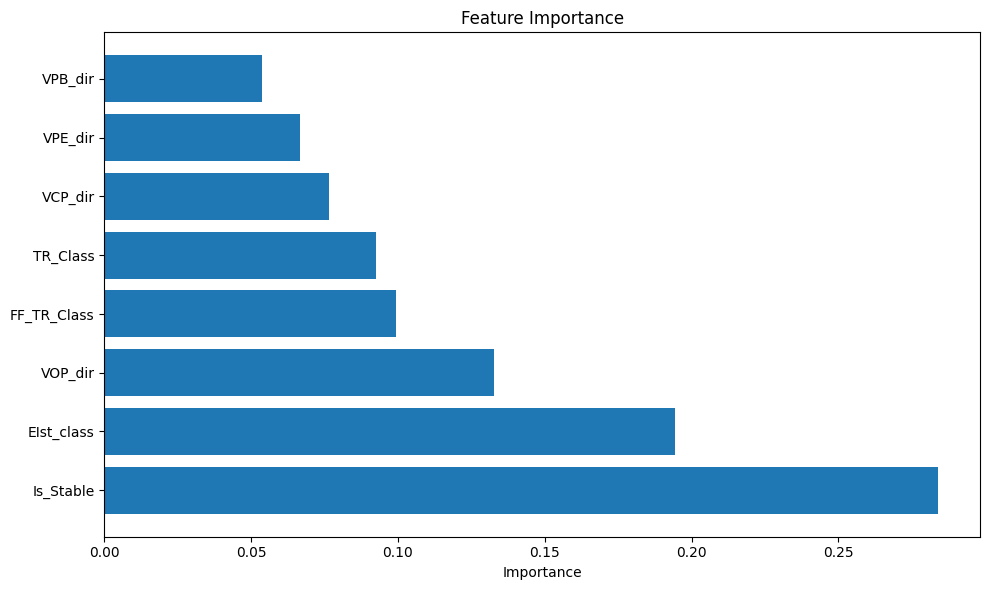

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

Sample Decision Rules:
 |--- Is_Stable = False0
|   |--- VPB_dir = down0
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 1.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 1.0
|   |--- VPB_dir >  0.50
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 0.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- EIst_class = neutral0
|   |   |   |   |--- class: 0.0
|   |   |   |--- EIst_class >  0.50
|   |   |   |   |--- class: 0.0
|--- Is_Stable >  0.50
|   |--- VCP_dir = down0
|   |   |--- EIst_class = neutral0
|   |   |   |--- VOP_dir = down0
|   |   |   |   |--- FF_TR_Class = High0
|   |   |   |   |   |--- TR_Class = High0
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- TR_Class >  0.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- FF_TR_Class >  0.50
|   |   |   |   |   |--- class: 0.0
|   |  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import export_text
import matplotlib.pyplot as plt

def optimized_rf_training_labelencoded(df, target_col="label", random_state=42, n_iter=50):
    """
    Optimized Random Forest training with label encoded categorical features.

    Args:
        df: Input DataFrame with categorical features
        target_col: Name of target column (default: "label")
        random_state: Random seed (default: 42)
        n_iter: Number of iterations for RandomizedSearchCV (default: 50)

    Returns:
        Dictionary containing:
        - best_params: Optimal parameters
        - feature_importance: DataFrame of feature importances
        - sample_tree_rules: Decision rules from first tree
        - label_encoders: Dictionary of fitted LabelEncoders for each column
    """
    # Step 1: Label encode categorical features
    categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']

    X = df[categorical_cols].copy()
    y = df[target_col]

    # Initialize and store label encoders for each column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # Step 2: Optimized hyperparameter search
    param_dist = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.8],
        "class_weight": [None, "balanced"]
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rf = RandomForestClassifier(random_state=random_state)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )

    search.fit(X, y)

    # Step 3: Extract results
    best_rf = search.best_estimator_

    # Feature importance
    importances = best_rf.feature_importances_
    feature_importance = pd.DataFrame({
        "Feature": categorical_cols,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    # Decision rules from first tree (with original category names)
    first_tree = best_rf.estimators_[0]

    # Create mapping for readable rule output
    feature_name_mapping = {i: f"{col}={val}"
                           for i, col in enumerate(categorical_cols)
                           for val in label_encoders[col].classes_}

    tree_rules = export_text(first_tree, feature_names=categorical_cols)

    # Replace encoded values with original categories in the rules
    for col in categorical_cols:
        for val_idx, val in enumerate(label_encoders[col].classes_):
            tree_rules = tree_rules.replace(f"{col} <= {val_idx}.5", f"{col} = {val}")
            tree_rules = tree_rules.replace(f"{col} <= {val_idx}", f"{col} = {val}")

    # Plot top features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"],
             feature_importance["Importance"])
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    return {
        "best_params": search.best_params_,
        "feature_importance": feature_importance,
        "sample_tree_rules": tree_rules,
        "label_encoders": label_encoders
    }

# Example usage
if __name__ == "__main__":
    # Load your data
    # shasta_final = pd.read_csv(...)

    results = optimized_rf_training_labelencoded(shasta_final, n_iter=30)
    print("Best Parameters:", results["best_params"])
    print("\nSample Decision Rules:\n", results["sample_tree_rules"])
    print("\nTop Features:\n", results["feature_importance"].head(10))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


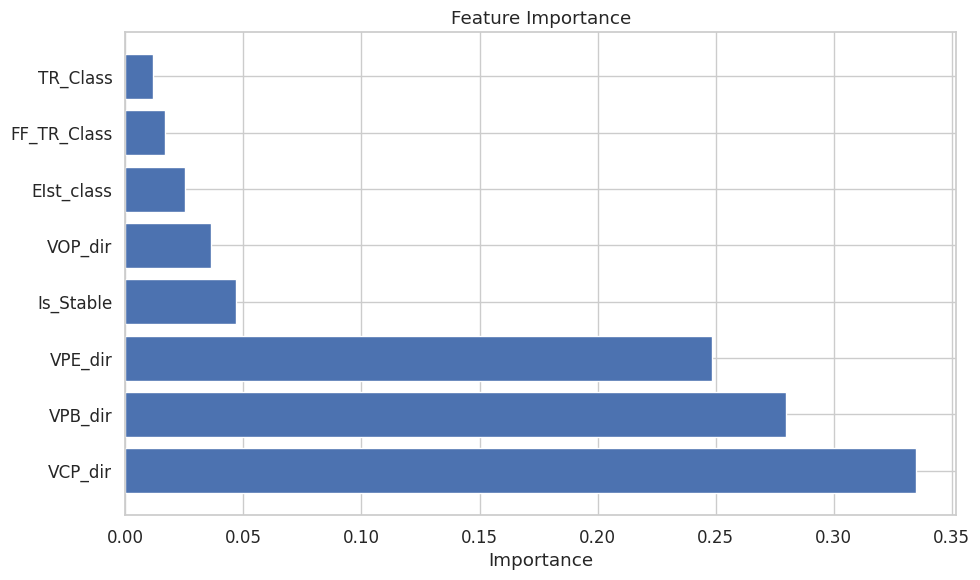

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'class_weight': None}

Sample Decision Rules:
 |--- Is_Stable = False0
|   |--- VPB_dir = down0
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 0.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 0.0
|   |--- VPB_dir >  0.50
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 1.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 1.0
|--- Is_Stable >  0.50
|   |--- VOP_dir = down0
|   |   |--- EIst_class = non_negative0
|   |   |   |--- class: 0.0
|   |   |--- EIst_class >  1.50
|   |   |   |--- class: 0.0
|   |--- VOP_dir >  0.50
|   |   |--- EIst_class = neutral0
|   |   |   |--- class: 0.0
|   |   |--- EIst_class >  0.50
|   |   |   |--- class: 0.0


Top Features:
        Feature  Importance
0      VCP_dir    0.335055
4      VPB_dir    0.279749
3      VPE_dir    0.248681
5    Is_Stable    0.046857
1      VOP_dir    0.036150
7   EIst_class    0.025

In [ ]:
results = optimized_rf_training_labelencoded(mellat_final, n_iter=30)
print("Best Parameters:", results["best_params"])
print("\nSample Decision Rules:\n", results["sample_tree_rules"])
print("\nTop Features:\n", results["feature_importance"].head(10))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


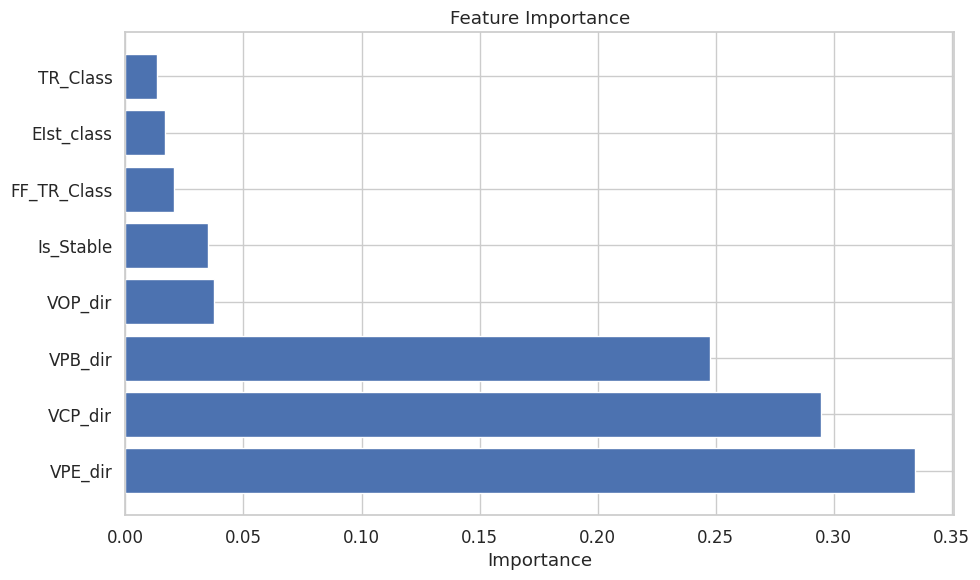

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'class_weight': 'balanced'}

Sample Decision Rules:
 |--- VCP_dir = down0
|   |--- TR_Class = High0
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 1.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 0.0
|   |--- TR_Class >  0.50
|   |   |--- Is_Stable = False0
|   |   |   |--- class: 0.0
|   |   |--- Is_Stable >  0.50
|   |   |   |--- class: 0.0
|--- VCP_dir >  0.50
|   |--- VOP_dir = down0
|   |   |--- Is_Stable = False0
|   |   |   |--- class: 1.0
|   |   |--- Is_Stable >  0.50
|   |   |   |--- class: 1.0
|   |--- VOP_dir >  0.50
|   |   |--- EIst_class = strong_negative0
|   |   |   |--- class: 1.0
|   |   |--- EIst_class >  2.50
|   |   |   |--- class: 0.0


Top Features:
        Feature  Importance
3      VPE_dir    0.334373
0      VCP_dir    0.294781
4      VPB_dir    0.247602
1      VOP_dir    0.037583
5    Is_Stable    0.034991
6  FF_TR_Class 

In [ ]:
results = optimized_rf_training_labelencoded(foolad_final, n_iter=30)
print("Best Parameters:", results["best_params"])
print("\nSample Decision Rules:\n", results["sample_tree_rules"])
print("\nTop Features:\n", results["feature_importance"].head(10))

In [ ]:
import scipy.stats as stats
import numpy as np

def cramers_v(x, y):
    """Calculate Cram√©r's V statistic for categorical-categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']
# Calculate for all features
correlations = {}
for col in categorical_cols:
    correlations[col] = cramers_v(shasta_final[col], shasta_final['label'])

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Cramers_V'])
print(corr_df.sort_values('Cramers_V', ascending=False))

             Cramers_V
Is_Stable     0.182243
FF_TR_Class   0.137164
TR_Class      0.091465
VCP_dir       0.088966
VPB_dir       0.088966
VPE_dir       0.088966
VOP_dir       0.087096
EIst_class    0.000000


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Label encode first (if not already done)
X_encoded = shasta_final[categorical_cols].apply(LabelEncoder().fit_transform)
mi = mutual_info_classif(X_encoded, shasta_final['label'])

mi_df = pd.DataFrame({'Feature': categorical_cols, 'Mutual_Info': mi})
print(mi_df.sort_values('Mutual_Info', ascending=False))

       Feature  Mutual_Info
5    Is_Stable     0.011789
6  FF_TR_Class     0.003125
3      VPE_dir     0.002988
0      VCP_dir     0.002349
4      VPB_dir     0.000397
7   EIst_class     0.000190
2     TR_Class     0.000000
1      VOP_dir     0.000000


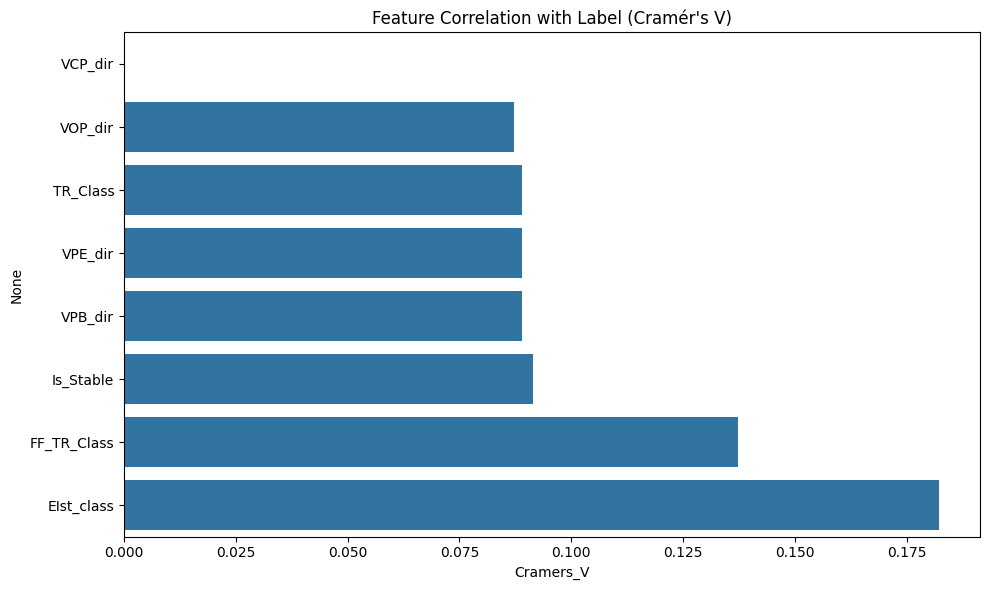

In [ ]:
import seaborn as sns

# For Cramer's V results
plt.figure(figsize=(10, 6))
sns.barplot(x='Cramers_V', y=corr_df.index, data=corr_df.sort_values('Cramers_V'))
plt.title("Feature Correlation with Label (Cram√©r's V)")
plt.tight_layout()
plt.show()

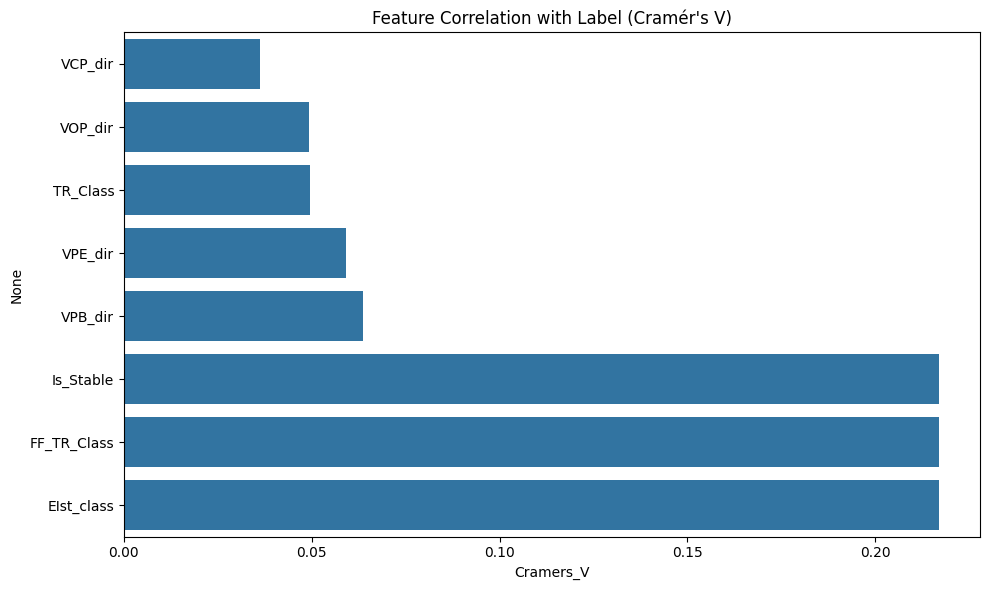

             Cramers_V
VCP_dir       0.217020
VPE_dir       0.217020
VPB_dir       0.217020
VOP_dir       0.063647
Is_Stable     0.059112
FF_TR_Class   0.049500
EIst_class    0.049153
TR_Class      0.036226


In [ ]:
categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']
# Calculate for all features
correlations = {}
for col in categorical_cols:
    correlations[col] = cramers_v(mellat_final[col], mellat_final['label'])

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Cramers_V'])

# For Cramer's V results
plt.figure(figsize=(10, 6))
sns.barplot(x='Cramers_V', y=corr_df.index, data=corr_df.sort_values('Cramers_V'))
plt.title("Feature Correlation with Label (Cram√©r's V)")
plt.tight_layout()
plt.show()
print(corr_df.sort_values('Cramers_V', ascending=False))

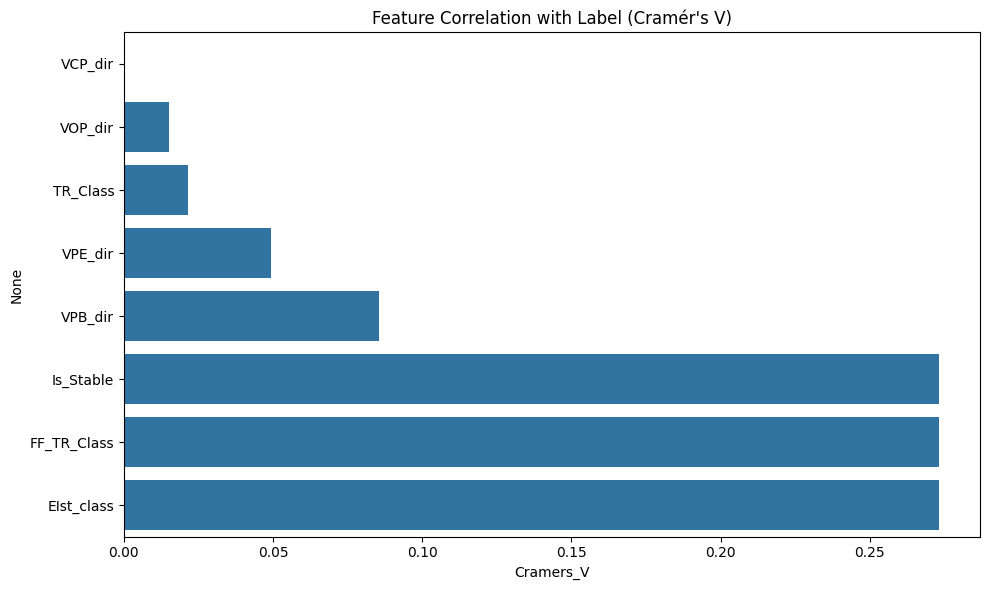

             Cramers_V
VCP_dir       0.273316
VPE_dir       0.273316
VPB_dir       0.273316
VOP_dir       0.085500
FF_TR_Class   0.049143
EIst_class    0.021440
Is_Stable     0.015051
TR_Class      0.000000


In [ ]:
categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']
# Calculate for all features
correlations = {}
for col in categorical_cols:
    correlations[col] = cramers_v(foolad_final[col], foolad_final['label'])

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Cramers_V'])

# For Cramer's V results
plt.figure(figsize=(10, 6))
sns.barplot(x='Cramers_V', y=corr_df.index, data=corr_df.sort_values('Cramers_V'))
plt.title("Feature Correlation with Label (Cram√©r's V)")
plt.tight_layout()
plt.show()
print(corr_df.sort_values('Cramers_V', ascending=False))

## merge datasets

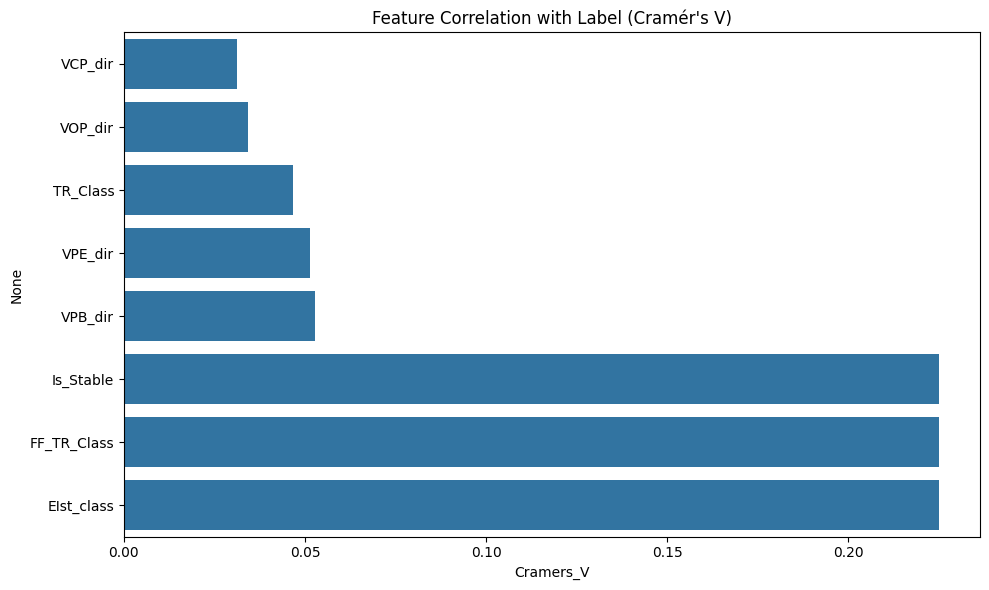

             Cramers_V
VCP_dir       0.225136
VPE_dir       0.225136
VPB_dir       0.225136
FF_TR_Class   0.052884
VOP_dir       0.051430
Is_Stable     0.046666
EIst_class    0.034197
TR_Class      0.031264


In [ ]:
final_df = pd.concat([shasta_final, mellat_final, foolad_final])
final_df = final_df.sample(frac=1)

categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']
# Calculate for all features
correlations = {}
for col in categorical_cols:
    correlations[col] = cramers_v(final_df[col], final_df['label'])

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Cramers_V'])

# For Cramer's V results
plt.figure(figsize=(10, 6))
sns.barplot(x='Cramers_V', y=corr_df.index, data=corr_df.sort_values('Cramers_V'))
plt.title("Feature Correlation with Label (Cram√©r's V)")
plt.tight_layout()
plt.show()
print(corr_df.sort_values('Cramers_V', ascending=False))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


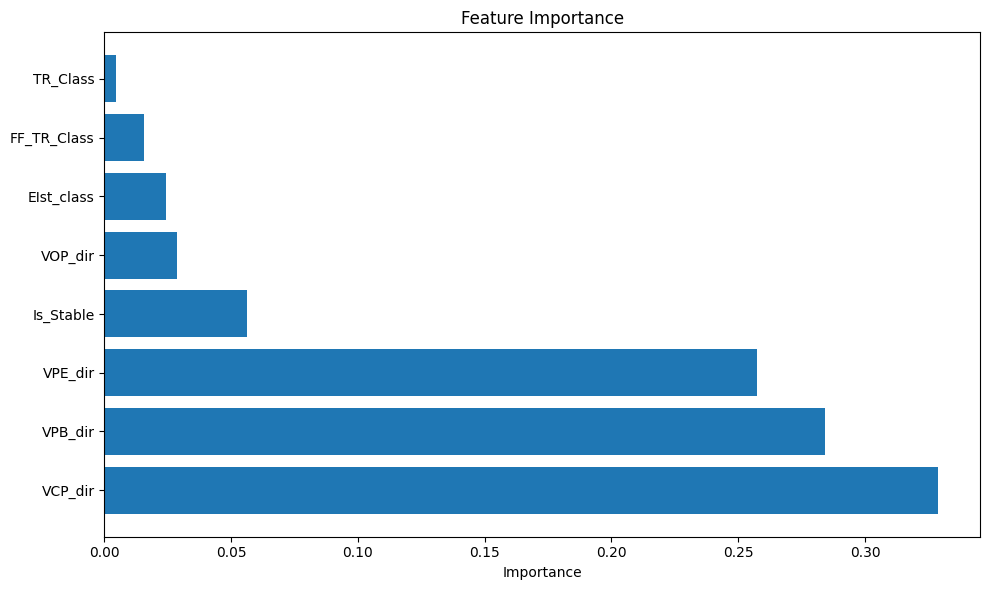

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 3, 'class_weight': None}

Sample Decision Rules:
 |--- VCP_dir = down0
|   |--- Is_Stable = False0
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 0.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 0.0
|   |--- Is_Stable >  0.50
|   |   |--- VOP_dir = down0
|   |   |   |--- class: 0.0
|   |   |--- VOP_dir >  0.50
|   |   |   |--- class: 0.0
|--- VCP_dir >  0.50
|   |--- EIst_class = non_negative0
|   |   |--- Is_Stable = False0
|   |   |   |--- class: 1.0
|   |   |--- Is_Stable >  0.50
|   |   |   |--- class: 1.0
|   |--- EIst_class >  1.50
|   |   |--- Is_Stable = False0
|   |   |   |--- class: 0.0
|   |   |--- Is_Stable >  0.50
|   |   |   |--- class: 0.0


Top Features:
        Feature  Importance
0      VCP_dir    0.328880
4      VPB_dir    0.284131
3      VPE_dir    0.257395
5    Is_Stable    0.056233
1      VOP_dir    0.028748
7   EIst_class    0.02449

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import export_text
import matplotlib.pyplot as plt

def optimized_rf_training_labelencoded(df, target_col="label", random_state=42, n_iter=50):
    # Step 1: Label encode categorical features
    categorical_cols = ['VCP_dir', 'VOP_dir', 'TR_Class', 'VPE_dir',
                       'VPB_dir', 'Is_Stable', 'FF_TR_Class', 'EIst_class']

    X = df[categorical_cols].copy()
    y = df[target_col]

    # Initialize and store label encoders for each column
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # Step 2: Optimized hyperparameter search
    param_dist = {
        "n_estimators": [20, 50, 100, 150],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.8],
        "class_weight": [None, "balanced"]
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rf = RandomForestClassifier(random_state=random_state)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )

    search.fit(X, y)

    # Step 3: Extract results
    best_rf = search.best_estimator_

    # Feature importance
    importances = best_rf.feature_importances_
    feature_importance = pd.DataFrame({
        "Feature": categorical_cols,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    # Decision rules from first tree (with original category names)
    first_tree = best_rf.estimators_[0]

    # Create mapping for readable rule output
    feature_name_mapping = {i: f"{col}={val}"
                           for i, col in enumerate(categorical_cols)
                           for val in label_encoders[col].classes_}

    tree_rules = export_text(first_tree, feature_names=categorical_cols)

    # Replace encoded values with original categories in the rules
    for col in categorical_cols:
        for val_idx, val in enumerate(label_encoders[col].classes_):
            tree_rules = tree_rules.replace(f"{col} <= {val_idx}.5", f"{col} = {val}")
            tree_rules = tree_rules.replace(f"{col} <= {val_idx}", f"{col} = {val}")

    # Plot top features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"],
             feature_importance["Importance"])
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    return {
        "best_params": search.best_params_,
        "feature_importance": feature_importance,
        "sample_tree_rules": tree_rules,
        "label_encoders": label_encoders
    }

if __name__ == "__main__":
    results = optimized_rf_training_labelencoded(final_df, n_iter=30)
    print("Best Parameters:", results["best_params"])
    print("\nSample Decision Rules:\n", results["sample_tree_rules"])
    print("\nTop Features:\n", results["feature_importance"].head(10))

In [ ]:
final_df = pd.concat([shasta_final, mellat_final, foolad_final])
final_df = final_df.sample(frac=1)


=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===


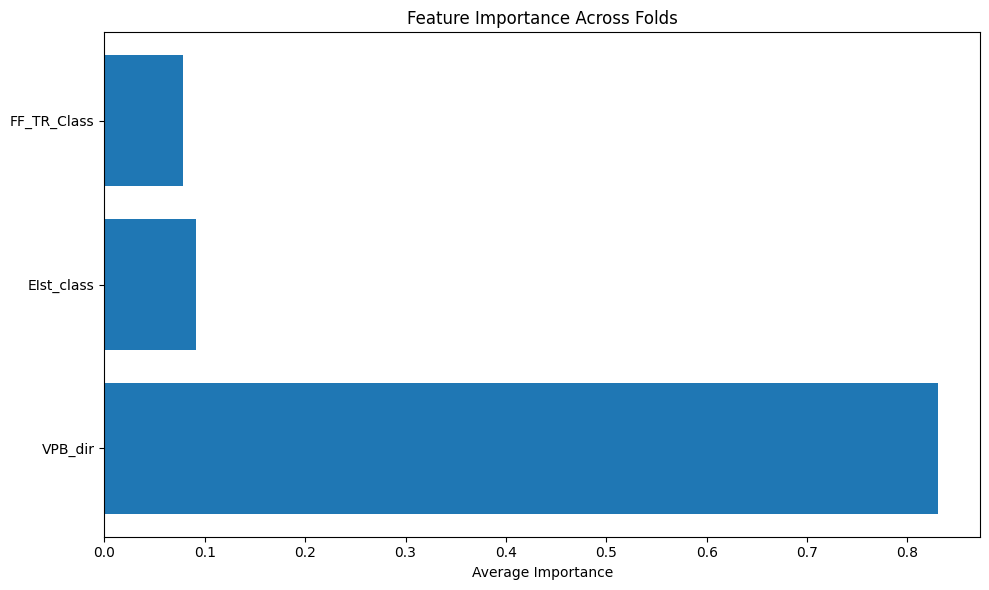


=== Cross-Validation Metrics ===
   fold  accuracy  precision    recall        f1  \
0     1  0.602327   0.555414  0.652695  0.600138   
1     2  0.613279   0.554795  0.627907  0.589091   
2     3  0.621492   0.579652  0.644345  0.610289   
3     4  0.618070   0.586158  0.610294  0.597983   
4     5  0.596851   0.555263  0.627043  0.588974   

                                         best_params  
0  {'n_estimators': 50, 'min_samples_split': 5, '...  
1  {'n_estimators': 150, 'min_samples_split': 2, ...  
2  {'n_estimators': 50, 'min_samples_split': 5, '...  
3  {'n_estimators': 150, 'min_samples_split': 5, ...  
4  {'n_estimators': 50, 'min_samples_split': 5, '...  

=== Best Parameters ===
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': None}

=== Feature Importance ===
       Feature  Importance
0      VPB_dir    0.830752
2   EIst_class    0.091374
1  FF_TR_Class    0.077875

=== Sample Decision Rules ===
|

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


def kfold_timeseries_rf(df, target_col="label", n_splits=5, n_iter=30, random_state=42):
    # best_test_data = {}
    # Label Encoding
    categorical_cols = [
                       'VPB_dir', 'FF_TR_Class', 'EIst_class']

    # categorical_cols = ['VPE_dir','VOP_dir',
                      #  'VPB_dir', 'Is_Stable', 'EIst_class']

    X = df[categorical_cols].copy()
    y = df[target_col]

    # Initialize encoders
    label_encoders = {col: LabelEncoder().fit(X[col]) for col in categorical_cols}
    X = X.apply(lambda col: label_encoders[col.name].transform(col))

    # TimeSeries K-Fold
    tscv = TimeSeriesSplit(n_splits=n_splits)
    param_dist = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 5, 7, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.8],
        "class_weight": [None, "balanced"]
    }

    # Store results
    fold_metrics = []
    feature_importances = []
    best_models = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # RandomizedSearchCV within training fold
        search = RandomizedSearchCV(
            RandomForestClassifier(random_state=random_state),
            param_dist,
            n_iter=n_iter,
            cv=TimeSeriesSplit(n_splits=3),
            scoring='accuracy',
            n_jobs=-1,
            random_state=random_state
        )
        search.fit(X_train, y_train)
        best_rf = search.best_estimator_

        # Predictions
        y_pred = best_rf.predict(X_test)

        # Store metrics
        fold_metrics.append({
            'fold': fold+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'best_params': search.best_params_
        })

        # Store feature importance
        feature_importances.append(best_rf.feature_importances_)
        best_models.append(best_rf)

    # Aggregate results
    metrics_df = pd.DataFrame(fold_metrics)
    avg_feature_importance = pd.DataFrame({
        'Feature': categorical_cols,
        'Importance': np.mean(feature_importances, axis=0)
    }).sort_values('Importance', ascending=False)

    # Get rules from best overall model (highest accuracy)
    best_model_idx = np.argmax(metrics_df['accuracy'])
    best_model = best_models[best_model_idx]
    first_tree = best_model.estimators_[0]
    tree_rules = export_text(first_tree, feature_names=categorical_cols)

    # Decode rules to original categories
    for col in categorical_cols:
        for val_idx, val in enumerate(label_encoders[col].classes_):
            tree_rules = tree_rules.replace(f"{col} <= {val_idx}.5", f"{col} = {val}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(avg_feature_importance['Feature'], avg_feature_importance['Importance'])
    plt.xlabel('Average Importance')
    plt.title('Feature Importance Across Folds')
    plt.tight_layout()
    plt.show()

    best_fold = np.argmax(metrics_df['accuracy'])
    # Retrieve train/test indices for best fold again
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = list(tscv.split(X))
    train_idx, test_idx = splits[best_fold]
    X_test_best = X.iloc[test_idx]
    y_test_best = y.iloc[test_idx]

    return {
        'cv_results': metrics_df,
        'feature_importance': avg_feature_importance,
        'best_params': metrics_df.loc[best_model_idx, 'best_params'],
        'sample_rules': tree_rules,
        'label_encoders': label_encoders,
        'best_model': best_model,  # Return the best model for further analysis
        'X_test_best': X_test_best,
        'y_test_best': y_test_best
    }

# Example usage
if __name__ == "__main__":
    results = kfold_timeseries_rf(final_df, n_splits=5, n_iter=30)

    print("\n=== Cross-Validation Metrics ===")
    print(results['cv_results'])

    print("\n=== Best Parameters ===")
    print(results['best_params'])

    print("\n=== Feature Importance ===")
    print(results['feature_importance'])

    print("\n=== Sample Decision Rules ===")
    print(results['sample_rules'])

In [ ]:
def extract_rules_with_metrics(rf_model, X_test, y_test, label_encoders, n_trees=10):
    """
    Extract rules from multiple trees and evaluate their performance.

    Args:
        rf_model: Trained Random Forest model
        X_test: Test features (label encoded)
        y_test: Test labels
        label_encoders: Dict of label encoders for categorical features
        n_trees: Number of trees to extract rules from

    Returns:
        DataFrame of rules with their precision, recall, and coverage
    """
    rules = []

    for i, tree in enumerate(rf_model.estimators_[:n_trees]):
        tree_rules = export_text(tree, feature_names=X_test.columns.tolist())

        # Decode label-encoded values to original categories in the rule text
        for col in label_encoders:
            for val_idx, val in enumerate(label_encoders[col].classes_):
                tree_rules = tree_rules.replace(
                    f"{col} <= {val_idx}.5",
                    f"{col} = {val}"
                )

        # Split into individual rules (one per leaf node)
        for rule in tree_rules.split('\n'):
            if 'class:' in rule:
                # Parse conditions and predicted class
                conditions = [c.strip() for c in rule.split('class:')[0].split('and')]
                pred_class = int(float(rule.split('class: ')[1]))

                # Evaluate rule coverage on test set
                mask = np.ones(len(X_test), dtype=bool)
                for cond in conditions:
                    if '<=' in cond:
                        col, val = cond.split('<=')
                        col = col.strip()
                        val = float(val.strip())
                        mask &= (X_test[col] <= val)
                    elif '=' in cond:
                        col, val = cond.split('=')
                        col = col.strip()
                        val = val.strip()
                        val_encoded = label_encoders[col].transform([val])[0]
                        mask &= (X_test[col] == val_encoded)

                if mask.sum() > 0:  # Only consider rules applying to some test samples
                    precision = precision_score(y_test[mask], [pred_class] * mask.sum(), zero_division=0)
                    recall = recall_score(y_test[mask], [pred_class] * mask.sum(), zero_division=0)
                    coverage = mask.sum() / len(X_test)

                    rules.append({
                        'rule': ' AND '.join(conditions),
                        'prediction': pred_class,
                        'precision': precision,
                        'recall': recall,
                        'coverage': coverage,
                        'tree': i
                    })

    return pd.DataFrame(rules)


In [ ]:
def select_best_rules(rules_df, min_precision=0.8, min_coverage=0.05):
    """Filter rules by precision and coverage thresholds."""
    return rules_df[
        (rules_df['precision'] >= min_precision) &
        (rules_df['coverage'] >= min_coverage)
    ].sort_values(['precision', 'coverage'], ascending=[False, False])

In [ ]:
# After training your model (from previous code)
rules_df = extract_rules_with_metrics(
    results['best_model'],
    results['X_test_best'],
    results['y_test_best'],
    results['label_encoders'],
    n_trees=20
)

best_rules = select_best_rules(rules_df)
print("=== Top 5 Rules ===")
print(best_rules[['rule', 'prediction', 'precision', 'coverage']].head())

=== Top 5 Rules ===
Empty DataFrame
Columns: [rule, prediction, precision, coverage]
Index: []


In [ ]:
# Extract rules without any filtering
rules_df = extract_rules_with_metrics(results['best_model'], X_test, y_test, results['label_encoders'], n_trees=20)

# Just print top 10 rules sorted by precision (descending)
print(rules_df.sort_values(by='precision', ascending=False).head(10))


NameError: name 'X_test' is not defined

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def extract_decision_rules(model, feature_names, label_encoders):
    """Safer rule extraction that filters malformed outputs"""
    all_rules = []
    for tree in model.estimators_:
        try:
            tree_rules = export_text(tree, feature_names=feature_names)
            for col in label_encoders:
                for val_idx, val in enumerate(label_encoders[col].classes_):
                    tree_rules = tree_rules.replace(
                        f"{col} <= {val_idx}.5",
                        f"{col} = {val}"
                    )
            all_rules.extend([r for r in tree_rules.split('\n') if 'class:' in r])
        except:
            continue
    return all_rules

def evaluate_rule_performance(rule, X_test, y_test, label_encoders):
    """Robust rule evaluation with comprehensive error handling"""
    try:
        if not isinstance(rule, str) or 'class:' not in rule:
            return None

        conditions, pred = rule.split('class:')
        pred_class = int(float(pred.strip()))
        conditions = [c.strip() for c in conditions.split('and') if c.strip()]

        if not conditions:
            return None

        mask = np.ones(len(X_test), dtype=bool)
        for cond in conditions:
            if '<=' in cond:
                parts = cond.split('<=')
                if len(parts) != 2:
                    continue
                col, val = parts
                col = col.strip()
                try:
                    val = float(val.strip())
                    mask &= (X_test[col] <= val)
                except:
                    continue
            elif '=' in cond:
                parts = cond.split('=')
                if len(parts) != 2:
                    continue
                col, val = parts
                col = col.strip()
                val = val.strip()
                try:
                    val_encoded = label_encoders[col].transform([val])[0]
                    mask &= (X_test[col] == val_encoded)
                except:
                    continue

        if sum(mask) == 0:
            return None

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            return {
                'rule': ' AND '.join(conditions),
                'prediction': pred_class,
                'precision': precision_score(y_test[mask], [pred_class]*sum(mask), zero_division=0),
                'recall': recall_score(y_test[mask], [pred_class]*sum(mask), zero_division=0),
                'coverage': sum(mask) / len(X_test)
            }
    except Exception as e:
        return None

In [ ]:
# Skip rules with low coverage
rules_df = results['all_rules'].dropna()
rules_df = rules_df[rules_df['coverage'] > 0.01]

KeyError: 'all_rules'

In [ ]:
def kfold_timeseries_rf(df, target_col="label", n_splits=5, n_iter=30, random_state=42):
    """Enhanced version with guaranteed all_rules output"""
    # ... (previous code until the rule evaluation part) ...

    # Initialize all_rules as empty DataFrame with correct columns
    all_rules = pd.DataFrame(columns=['rule', 'prediction', 'precision', 'recall', 'coverage', 'fold'])

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # ... (previous training code) ...

        # Rule extraction with error handling
        try:
            rules = extract_decision_rules(best_rf, categorical_cols, label_encoders)
            for rule in rules:
                rule_metrics = evaluate_rule_performance(rule, X_test, y_test, label_encoders)
                if rule_metrics:
                    rule_metrics['fold'] = fold+1
                    all_rules = pd.concat([
                        all_rules,
                        pd.DataFrame([rule_metrics])
                    ], ignore_index=True)
        except Exception as e:
            print(f"Rule extraction failed in fold {fold+1}: {str(e)}")
            continue

    # Ensure we always return all_rules even if empty
    if all_rules.empty:
        all_rules = pd.DataFrame(columns=['rule', 'prediction', 'precision', 'recall', 'coverage', 'fold'])

    # ... (rest of your code) ...

    return {
        'cv_results': metrics_df,
        'feature_importance': avg_feature_importance,
        'all_rules': all_rules,  # Now guaranteed to exist
        'label_encoders': label_encoders
    }

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Concatenate all stock datasets with identifier
stocks = {
    'Stock_A': shasta_final,
    'Stock_B': mellat_final,
    'Stock_C': foolad_final
}

# Add stock identifier and concatenate
final_df = pd.concat([
    df.assign(stock_id=name) for name, df in stocks.items()
])

# Label encode categorical features
categorical_cols = ['VPB_dir', 'FF_TR_Class', 'EIst_class']
label_encoders = {col: LabelEncoder().fit(final_df[col]) for col in categorical_cols}
final_df[categorical_cols] = final_df[categorical_cols].apply(
    lambda col: label_encoders[col.name].transform(col)
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import export_text

def extract_rules(model, feature_names, label_encoders):
    """Extract human-readable rules from all trees"""
    rules = []
    for tree in model.estimators_:
        tree_rules = export_text(tree, feature_names=feature_names)
        # Decode encoded values to original categories
        for col in label_encoders:
            for val_idx, val in enumerate(label_encoders[col].classes_):
                tree_rules = tree_rules.replace(
                    f"{col} <= {val_idx}.5",
                    f"{col} = {val}"
                )
        rules.extend(tree_rules.split('\n'))
    return [r for r in rules if 'class:' in r]

def evaluate_rule(rule, X, y, label_encoders):
    """Evaluate rule performance (precision/recall/coverage)"""
    try:
        conditions, pred = rule.split('class:')
        pred_class = int(float(pred.strip()))
        conditions = [c.strip() for c in conditions.split('and') if c.strip()]

        mask = np.ones(len(X), dtype=bool)
        for cond in conditions:
            if '=' in cond:
                col, val = cond.split('=')
                col, val = col.strip(), val.strip()
                val_encoded = label_encoders[col].transform([val])[0]
                mask &= (X[col] == val_encoded)

        if sum(mask) < 5:  # Skip rules with <5 samples
            return None

        return {
            'rule': ' AND '.join(conditions),
            'prediction': pred_class,
            'precision': (y[mask] == pred_class).mean(),
            'coverage': mask.mean()
        }
    except:
        return None

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
all_rules = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(final_df)):
    X_train, X_test = final_df.iloc[train_idx], final_df.iloc[test_idx]
    y_train, y_test = final_df['label'].iloc[train_idx], final_df['label'].iloc[test_idx]

    # Train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ).fit(X_train[categorical_cols], y_train)

    # Extract and evaluate rules
    rules = extract_rules(model, categorical_cols, label_encoders)
    for rule in rules:
        rule_metrics = evaluate_rule(rule, X_test[categorical_cols], y_test, label_encoders)
        if rule_metrics:
            rule_metrics['fold'] = fold + 1
            all_rules.append(rule_metrics)

In [ ]:
# Convert to DataFrame
rules_df = pd.DataFrame(all_rules)

# Filter high-quality rules (adjust thresholds as needed)
best_rules = rules_df[
    (rules_df['precision'] >= 0.75) &
    (rules_df['coverage'] >= 0.05)
].sort_values(['precision', 'coverage'], ascending=[False, False])

# Identify cross-stock rules
def is_rule_global(rule, stocks):
    """Check if rule appears in multiple stocks"""
    stock_coverage = []
    for stock_id, df in stocks.items():
        X_stock = df[categorical_cols].apply(
            lambda col: label_encoders[col.name].transform(col)
        )
        mask = np.ones(len(X_stock), dtype=bool)
        for cond in rule.split(' AND '):
            col, val = cond.split(' = ')
            val_encoded = label_encoders[col].transform([val])[0]
            mask &= (X_stock[col] == val_encoded)
        stock_coverage.append(mask.any())
    return sum(stock_coverage) >= 2  # Present in ‚â•2 stocks

best_rules['is_global'] = best_rules['rule'].apply(
    lambda r: is_rule_global(r, stocks)
)

# Final selection
final_rules = best_rules[
    (best_rules['is_global']) |
    (best_rules['precision'] >= 0.85)
].drop_duplicates('rule')

In [ ]:
print("=== Best Global Rules ===")
print(final_rules[final_rules['is_global']].head(10))

print("\n=== Best Stock-Specific Rules ===")
print(final_rules[~final_rules['is_global']].head(10))

# Export to CSV
final_rules.to_csv('best_stock_rules.csv', index=False)

=== Best Global Rules ===
Empty DataFrame
Columns: []
Index: []

=== Best Stock-Specific Rules ===
Empty DataFrame
Columns: []
Index: []


In [ ]:
final_df.head()

ticker       date   first    high     low   close         value  \
1256  Social Sec Inv 2020-04-13     0.0     0.0     0.0  1000.0  0.000000e+00   
1255  Social Sec Inv 2020-04-14     0.0     0.0     0.0  1000.0  0.000000e+00   
1254  Social Sec Inv 2020-04-15  8600.0  8600.0  8600.0  8600.0  5.761989e+13   
1253  Social Sec Inv 2020-04-18  9030.0  9030.0  9030.0  8889.0  8.468741e+10   
1252  Social Sec Inv 2020-04-19  9333.0  9333.0  9333.0  9027.0  4.054824e+10   

          volume  openint period  ...         PE  VPE_dir        PB VPB_dir  \
1256           0        0      D  ...   6.211180     down  0.228347       0   
1255           0        0      D  ...   6.211180       up  0.228347       1   
1254  6699987426  2061657      D  ...  53.416149       up  1.963782       1   
1253     9378451     2122      D  ...  55.211180       up  2.029774       1   
1252     4344609     2796      D  ...  56.068323       up  2.061286       1   

      Is_Stable     FF_TR  FF_TR_Class  label  EIst_class stock_id  
1256      False  0.000000            1      0           0  Stock_A  
1255      False  0.000000            1      1           0  Stock_A  
1254       True  0.031502            1      1           0  Stock_A  
1253      False  0.000044            1      1           0  Stock_A  
1252      False  0.000020            1      1           0  Stock_A  

[5 rows x 35 columns]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Combine your data
df = pd.concat([shasta_final, mellat_final, foolad_final])

# Define features
features = ['VPB_dir', 'FF_TR_Class', 'EIst_class']

# Map binary categorical features
df['VPB_dir'] = df['VPB_dir'].map({'low': 0, 'high': 1})
df['FF_TR_Class'] = df['FF_TR_Class'].map({'low': 0, 'high': 1})

# Map ordinal feature
ordinal_map = {
    'strong negative': 0,
    'negative': 1,
    'weak negative': 2
}
df['EIst_class'] = df['EIst_class'].map(ordinal_map)

# Prepare features and target
X = df[features]
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': None,
    'class_weight': 'balanced',
    'random_state': 42
}
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1441
           1       0.45      1.00      0.62      1190

    accuracy                           0.45      2631
   macro avg       0.23      0.50      0.31      2631
weighted avg       0.20      0.45      0.28      2631



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(df['label'].value_counts())

label
0    4752
1    4016
Name: count, dtype: int64


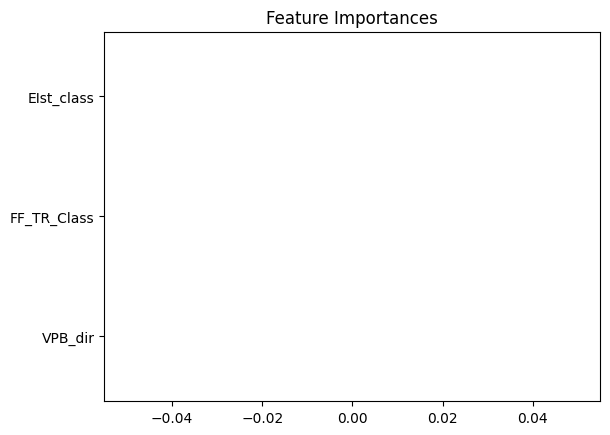

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns

plt.barh(feature_names, importances)
plt.title("Feature Importances")
plt.show()



=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===


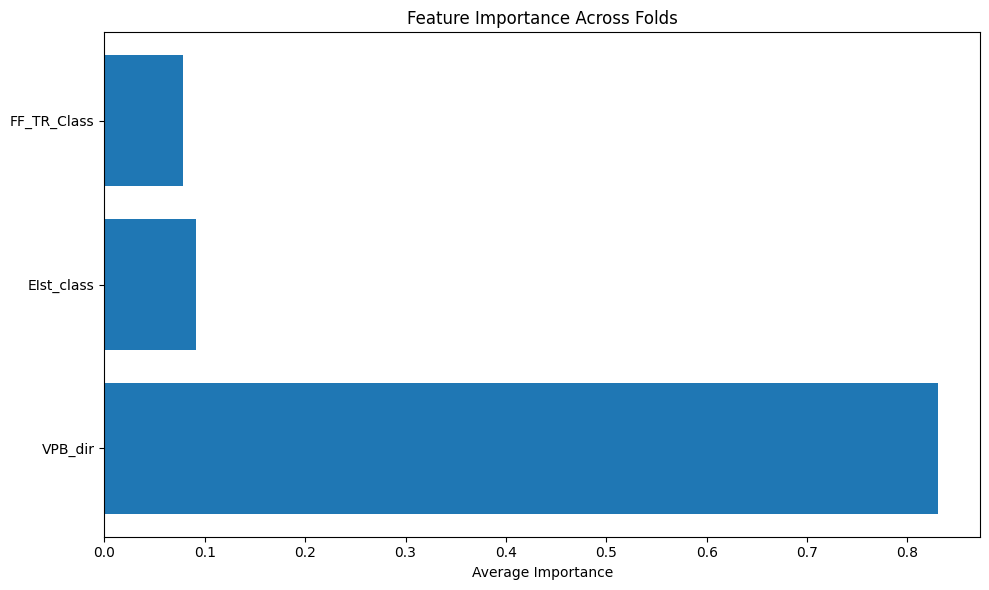


=== Top 20 Most Important Rules ===

Rule #1 (Score: 391.00)
Conditions: FF_TR_Class != High AND EIst_class = neutral AND VPB_dir != down
Outcome: class 1
Samples: 1173, Depth: 3

Rule #2 (Score: 387.67)
Conditions: FF_TR_Class != High AND EIst_class = neutral AND VPB_dir = down
Outcome: class 0
Samples: 1163, Depth: 3


In [ ]:
def extract_best_rules(results, n_top_trees=5, min_samples_leaf=10):
    """
    Final improved rule extraction with:
    - Contradiction detection
    - Rule consolidation
    - Better scoring
    """
    best_model = results['best_model']
    label_encoders = results['label_encoders']
    categorical_cols = list(label_encoders.keys())

    all_rules = []

    for i, tree in enumerate(best_model.estimators_[:n_top_trees]):
        tree_structure = tree.tree_
        feature_names = categorical_cols

        def recurse(node, depth, conditions_dict):
            if tree_structure.feature[node] == -2:  # Leaf node
                class_label = np.argmax(tree_structure.value[node])
                n_samples = tree_structure.n_node_samples[node]

                if n_samples >= min_samples_leaf:
                    # Convert conditions dict to readable string
                    conditions = []
                    for feat, vals in conditions_dict.items():
                        if len(vals['=']) > 0:
                            conditions.append(f"{feat} = {' or '.join(vals['='])}")
                        if len(vals['!=']) > 0:
                            conditions.append(f"{feat} != {' and '.join(vals['!='])}")

                    rule = {
                        'tree': i,
                        'conditions': " AND ".join(conditions),
                        'outcome': class_label,
                        'samples': n_samples,
                        'depth': depth,
                        'conditions_dict': conditions_dict.copy()
                    }
                    all_rules.append(rule)
                return

            feature = feature_names[tree_structure.feature[node]]
            threshold = tree_structure.threshold[node]

            # Handle categorical features
            if feature in label_encoders:
                classes = label_encoders[feature].classes_
                try:
                    threshold_val = classes[int(threshold)]
                except (IndexError, ValueError):
                    threshold_val = str(threshold)

                # Left branch: feature == threshold_val
                left_dict = conditions_dict.copy()
                if feature not in left_dict:
                    left_dict[feature] = {'=': set(), '!=': set()}
                left_dict[feature]['='].add(threshold_val)
                recurse(tree_structure.children_left[node], depth+1, left_dict)

                # Right branch: feature != threshold_val
                right_dict = conditions_dict.copy()
                if feature not in right_dict:
                    right_dict[feature] = {'=': set(), '!=': set()}
                right_dict[feature]['!='].add(threshold_val)
                recurse(tree_structure.children_right[node], depth+1, right_dict)
            else:
                # Handle numerical features
                left_dict = conditions_dict.copy()
                if feature not in left_dict:
                    left_dict[feature] = {'=': set(), '!=': set()}
                left_dict[feature]['='].add(f"<={threshold:.2f}")
                recurse(tree_structure.children_left[node], depth+1, left_dict)

                right_dict = conditions_dict.copy()
                if feature not in right_dict:
                    right_dict[feature] = {'=': set(), '!=': set()}
                right_dict[feature]['='].add(f">{threshold:.2f}")
                recurse(tree_structure.children_right[node], depth+1, right_dict)

        recurse(0, 0, {})

    # Score rules (higher score for more specific rules with good coverage)
    for rule in all_rules:
        specificity = sum(len(vals['=']) + len(vals['!=']) for vals in rule['conditions_dict'].values())
        rule['score'] = (rule['samples'] * specificity) / (rule['depth'] ** 2)

    # Remove contradictory and redundant rules
    unique_rules = []
    seen_conditions = set()

    for rule in sorted(all_rules, key=lambda x: -x['score']):
        # Check for contradictions
        has_contradiction = False
        for feat, vals in rule['conditions_dict'].items():
            if len(vals['=']) > 1:  # Can't have multiple '=' conditions
                has_contradiction = True
                break

        if has_contradiction:
            continue

        # Create normalized condition string
        norm_conditions = []
        for feat in sorted(rule['conditions_dict'].keys()):
            vals = rule['conditions_dict'][feat]
            if vals['=']:
                norm_conditions.append(f"{feat}={'|'.join(sorted(vals['=']))}")
            if vals['!=']:
                norm_conditions.append(f"{feat}!={'|'.join(sorted(vals['!=']))}")
        norm_condition = " AND ".join(norm_conditions)

        if norm_condition not in seen_conditions:
            seen_conditions.add(norm_condition)
            unique_rules.append(rule)

    return {
        'top_rules': unique_rules[:20],
        'feature_importances': dict(zip(categorical_cols, best_model.feature_importances_))
    }


if __name__ == "__main__":
    results = kfold_timeseries_rf(final_df, n_splits=5, n_iter=30)
    rule_results = extract_best_rules(results, n_top_trees=10, min_samples_leaf=20)

    print("\n=== Top 20 Most Important Rules ===")
    for i, rule in enumerate(rule_results['top_rules'], 1):
        print(f"\nRule #{i} (Score: {rule['score']:.2f})")
        print(f"Conditions: {rule['conditions']}")
        print(f"Outcome: class {rule['outcome']}")
        print(f"Samples: {rule['samples']}, Depth: {rule['depth']}")

In [ ]:
final_df['EIst_class'].unique()

array(['neutral', 'weak_negative', 'non_negative', 'strong_negative'],
      dtype=object)

In [ ]:
def extract_best_rules(results, n_top_trees=10, min_samples_leaf=20):
    best_model = results['best_model']
    X_test = results['X_test_best']
    y_test = results['y_test_best']
    label_encoders = results['label_encoders']

    # Get all rules first
    rules = []
    for i, tree in enumerate(best_model.estimators_[:n_top_trees]):
        tree_rules = export_text(tree, feature_names=list(label_encoders.keys()))

        # Process each rule
        for rule_line in tree_rules.split('\n'):
            if 'class:' in rule_line:
                try:
                    conditions, outcome = rule_line.split('class:')
                    outcome = outcome.strip()

                    # Decode conditions
                    for feat in label_encoders:
                        for val_idx, val in enumerate(label_encoders[feat].classes_):
                            conditions = conditions.replace(f"{feat} <= {val_idx}.5", f"{feat} = {val}")

                    # Evaluate rule performance
                    mask = pd.Series(True, index=X_test.index)
                    for cond in conditions.split('|')[:-1]:
                        if '<=' in cond:
                            feat, val = cond.split('<=')
                            feat = feat.strip()
                            val = float(val.strip())
                            mask &= (X_test[feat] <= val)
                        elif '=' in cond:
                            feat, val = cond.split('=')
                            feat = feat.strip()
                            val = val.strip()
                            mask &= (X_test[feat] == val)

                    if mask.sum() > 0:  # Only keep rules that match test data
                        precision = (y_test[mask] == int(outcome)).mean()
                        coverage = mask.mean()
                        rules.append({
                            'conditions': conditions.replace('|', 'AND').strip(),
                            'outcome': outcome,
                            'precision': precision,
                            'coverage': coverage,
                            'support': mask.sum()
                        })
                except:
                    continue

    # Filter and sort rules
    rules = sorted(rules, key=lambda x: (-x['precision'], -x['support']))[:20]

    # Remove duplicates
    unique_rules = []
    seen = set()
    for rule in rules:
        key = (rule['conditions'], rule['outcome'])
        if key not in seen:
            seen.add(key)
            unique_rules.append(rule)

    return unique_rules


=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===


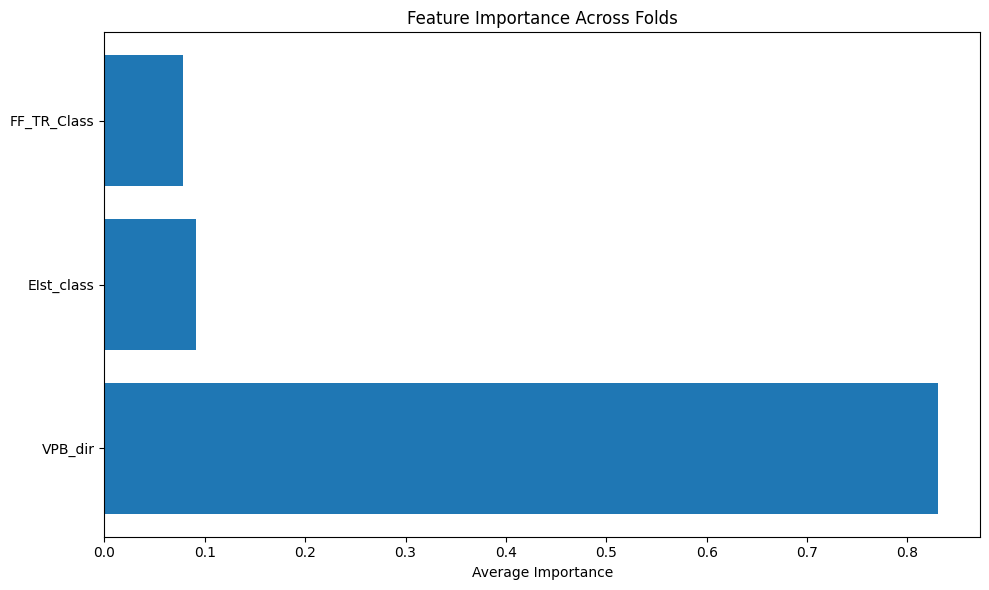


=== Top 0 Most Important Rules ===
Rule  Conditions                                                   Outcome  Precision  Coverage   Support   
--------------------------------------------------------------------------------------------------------------


In [ ]:
def extract_best_rules(results, n_top_trees=10, min_samples_leaf=20):
    """Extracts and evaluates decision rules from RandomForest with performance metrics"""
    best_model = results['best_model']
    X_test = results['X_test_best']
    y_test = results['y_test_best']
    label_encoders = results['label_encoders']

    # Get all rules first
    rules = []
    for i, tree in enumerate(best_model.estimators_[:n_top_trees]):
        tree_rules = export_text(tree, feature_names=list(label_encoders.keys()))

        # Process each rule
        for rule_line in tree_rules.split('\n'):
            if 'class:' in rule_line:
                try:
                    conditions, outcome = rule_line.split('class:')
                    outcome = outcome.strip()

                    # Decode conditions
                    for feat in label_encoders:
                        for val_idx, val in enumerate(label_encoders[feat].classes_):
                            conditions = conditions.replace(f"{feat} <= {val_idx}.5", f"{feat} = {val}")

                    # Evaluate rule performance
                    mask = pd.Series(True, index=X_test.index)
                    for cond in conditions.split('|')[:-1]:
                        cond = cond.strip()
                        if '<=' in cond:
                            feat, val = cond.split('<=')
                            feat = feat.strip()
                            val = float(val.strip())
                            mask &= (X_test[feat] <= val)
                        elif '=' in cond:
                            feat, val = cond.split('=')
                            feat = feat.strip()
                            val = val.strip()
                            mask &= (X_test[feat] == val)

                    if mask.sum() > min_samples_leaf:  # Only keep rules with sufficient support
                        precision = (y_test[mask] == int(outcome)).mean()
                        coverage = mask.mean()
                        rules.append({
                            'conditions': conditions.replace('|', 'AND').strip(),
                            'outcome': outcome,
                            'precision': precision,
                            'coverage': coverage,
                            'support': mask.sum()
                        })
                except Exception as e:
                    continue

    # Filter and sort rules by precision and support
    rules = sorted(rules, key=lambda x: (-x['precision'], -x['support']))

    # Remove duplicates
    unique_rules = []
    seen = set()
    for rule in rules:
        key = (rule['conditions'], rule['outcome'])
        if key not in seen:
            seen.add(key)
            unique_rules.append(rule)

    return unique_rules[:20]

def print_rules(rules):
    """Prints rules in a nicely formatted table"""
    print(f"\n=== Top {len(rules)} Most Important Rules ===")
    print(f"{'Rule':<5} {'Conditions':<60} {'Outcome':<8} {'Precision':<10} {'Coverage':<10} {'Support':<10}")
    print("-"*110)

    for i, rule in enumerate(rules, 1):
        print(f"{i:<5} {rule['conditions'][:59]:<60} {rule['outcome']:<8} "
              f"{rule['precision']:.3f}{'':<6} {rule['coverage']:.3f}{'':<6} {rule['support']:<10}")

# Example usage
if __name__ == "__main__":
    results = kfold_timeseries_rf(final_df, n_splits=5, n_iter=30)
    rules = extract_best_rules(results)
    print_rules(rules)


=== Fold 1/5 ===

=== Fold 2/5 ===

=== Fold 3/5 ===

=== Fold 4/5 ===

=== Fold 5/5 ===


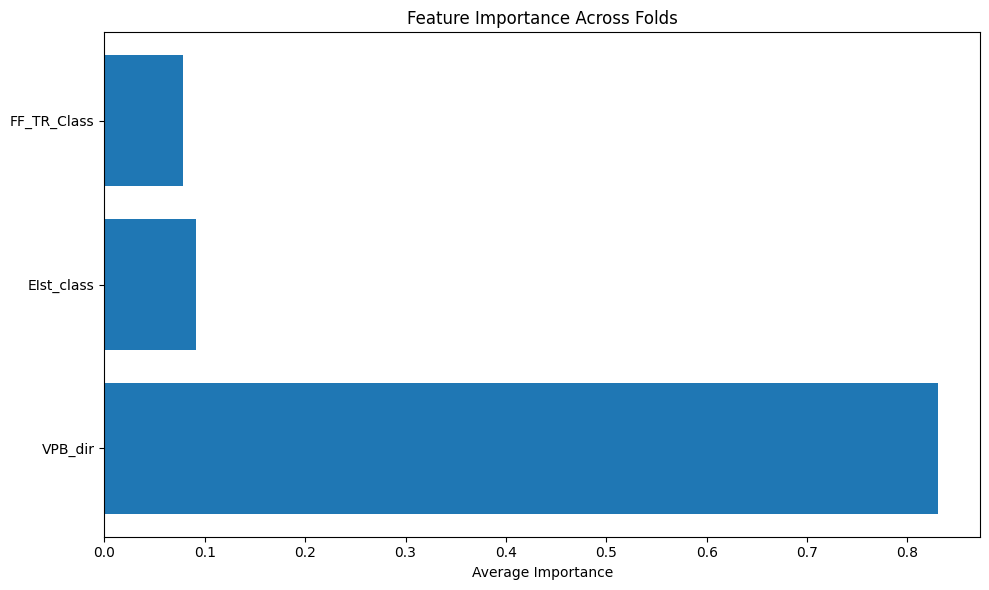

Found 794 meaningful rules

Sample of good rules:
1. Tree 0: IF VPB_dir = down AND FF_TR_Class = High AND EIst_class = strong_negative AND EIst_class = non_negative AND EIst_class = neutral THEN class 0 (samples: 150)
2. Tree 0: IF VPB_dir = down AND FF_TR_Class = High AND EIst_class = strong_negative AND EIst_class = non_negative AND EIst_class != neutral THEN class 0 (samples: 3)
3. Tree 0: IF VPB_dir = down AND FF_TR_Class = High AND EIst_class = strong_negative AND EIst_class != non_negative THEN class 0 (samples: 17)
4. Tree 0: IF VPB_dir = down AND FF_TR_Class = High AND EIst_class != strong_negative THEN class 0 (samples: 6)
5. Tree 0: IF VPB_dir = down AND FF_TR_Class != High AND EIst_class = neutral THEN class 0 (samples: 1153)
6. Tree 0: IF VPB_dir = down AND FF_TR_Class != High AND EIst_class != neutral AND EIst_class = strong_negative AND EIst_class = non_negative THEN class 0 (samples: 5)
7. Tree 0: IF VPB_dir = down AND FF_TR_Class != High AND EIst_class != neutral AND EI

In [ ]:
import numpy as np
from sklearn.tree import _tree

def extract_meaningful_rules(rf_model, feature_names, label_encoders):
    """Extracts actual conditions from random forest trees"""
    rules = []

    for tree_idx, tree in enumerate(rf_model.estimators_):
        tree_ = tree.tree_
        feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]

        def recurse(node, depth, conditions):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]

                # Handle categorical splits
                if name in label_encoders:
                    categories = label_encoders[name].classes_
                    try:
                        # For categorical features, threshold represents category index
                        cat_idx = int(threshold)
                        left_cond = f"{name} = {categories[cat_idx]}"
                        right_cond = f"{name} != {categories[cat_idx]}"
                    except:
                        left_cond = f"{name} <= {threshold}"
                        right_cond = f"{name} > {threshold}"
                else:
                    left_cond = f"{name} <= {threshold:.4f}"
                    right_cond = f"{name} > {threshold:.4f}"

                recurse(tree_.children_left[node], depth + 1, conditions + [left_cond])
                recurse(tree_.children_right[node], depth + 1, conditions + [right_cond])
            else:
                rule = {
                    'tree': tree_idx,
                    'conditions': " AND ".join(conditions),
                    'class': np.argmax(tree_.value[node]),
                    'samples': tree_.n_node_samples[node]
                }
                rules.append(rule)

        recurse(0, 0, [])

    return rules

# Usage:
if __name__ == "__main__":
    # Get your results first
    results = kfold_timeseries_rf(final_df)

    # Extract proper rules
    feature_names = list(results['label_encoders'].keys())
    rules = extract_meaningful_rules(
        results['best_model'],
        feature_names,
        results['label_encoders']
    )

    # Print some good rules
    print(f"Found {len(rules)} meaningful rules")
    print("\nSample of good rules:")
    for i, rule in enumerate(rules[:20]):
        if rule['conditions'].strip():  # Only show rules with actual conditions
            print(f"{i+1}. Tree {rule['tree']}: IF {rule['conditions']} THEN class {rule['class']} (samples: {rule['samples']})")

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming final_df is your prepared DataFrame
# Let's prepare the features and target variable
# final_df = df
# df = final_df
# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['VPB_dir', 'FF_TR_Class', 'EIst_class']
for col in categorical_cols:
    if col in final_df.columns:
        final_df[col] = le.fit_transform(final_df[col].astype(str))

# Select features - adjust based on what's available in final_df
feature_cols = ['VPB_dir', 'FF_TR_Class', 'EIst_class']

# Make sure we only use columns that exist in the dataframe
available_features = [col for col in feature_cols if col in final_df.columns]

# Prepare X and y
X = final_df[available_features]
y = final_df['label']

# # Drop rows with missing values (if any)
# X = X.dropna()
# y = y[X.index]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Initialize and train Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split = 5,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    max_depth=5,
    class_weight=None  # Helps with imbalanced classes
)

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Accuracy: 0.6020524515393386

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       942
           1       0.57      0.60      0.58       812

    accuracy                           0.60      1754
   macro avg       0.60      0.60      0.60      1754
weighted avg       0.60      0.60      0.60      1754


Feature Importance:
       Feature  Importance
0      VPB_dir    0.900457
2   EIst_class    0.062052
1  FF_TR_Class    0.037492


In [ ]:
import pandas as pd
from graphviz import Digraph

# # Sample data (replace with your dataset)
# data = {
#     'Reply': ['Denial', 'Rebuild', 'Denial', 'Diminish'],  # C1 (Most important)
#     'EIst_class': ['negative', 'non_negative', 'strong_negative', 'non_negative'],  # C2
#     'TR_Class': ['High', 'Low', 'High', 'Low'],  # C3
#     'label': [0, 1, 0, 1]
# }
# df = pd.DataFrame(data)

# Feature importance order (C1 > C2 > C3)
feature_order = ['VPB_dir', 'EIst_class', 'TR_Class']  # From RF's feature_importances_

# Discretize features and assign state IDs
states = []
for i, row in df.iterrows():
    state_id = f"s{i}"
    state = {
        'state_id': state_id,
        'VPB_dir': row['VPB_dir'],
        'EIst_class': row['EIst_class'],
        'TR_Class': row['TR_Class'],
        'label': row['label']
    }
    states.append(state)

# Generate transitions based on feature priority
transitions = []
for src in states:
    for dst in states:
        # Transition if a higher-priority feature changes (C1 > C2 > C3)
        if (src['VPB_dir'] != dst['VPB_dir']):  # C1 change
            transitions.append((src['state_id'], dst['state_id']))
        elif (src['EIst_class'] != dst['EIst_class']) and (src['VPB_dir'] == dst['VPB_dir']):  # C2 change
            transitions.append((src['state_id'], dst['state_id']))
        elif (src['TR_Class'] != dst['TR_Class']) and (src['EIst_class'] == dst['EIst_class']):  # C3 change
            transitions.append((src['state_id'], dst['state_id']))

In [ ]:
from graphviz import Digraph
import pandas as pd

# Configuration based on your requirements
FEATURE_ORDER = ['VPB_dir', 'EIst_class', 'TR_Class']  # Importance order
FEATURE_VALUES = {
    'VPB_dir': ['Up', 'Down'],
    'EIst_class': ['non_negative', 'strong_negative', 'weak_negative'],
    'TR_Class': ['high', 'low']
}
FINAL_STATES = ['UP', 'DOWN']

# Create the model
dot = Digraph(comment='Stock Movement Prediction Model')
dot.attr(rankdir='TB', splines='ortho')  # Top-to-bottom layout with straight lines
dot.attr('node', fontname='Helvetica')

# States will be named as: s_<depth>_<feature_value>
def state_name(path):
    return 's_' + '_'.join([f"{k[:2]}_{v[:2]}" for k,v in path])

# Build the tree recursively
def build_tree(parent_state, parent_name, remaining_features, path=[]):
    if not remaining_features:
        # Leaf node - connect to final state (you'll replace this with your actual rules)
        final_state = 'UP' if some_rule(path) else 'DOWN'  # Replace with your logic
        dot.node(final_state, final_state, shape='doublecircle',
                fillcolor='lightgreen' if final_state == 'UP' else 'lightcoral',
                style='filled')
        dot.edge(parent_name, final_state, label='')
        return

    current_feature = remaining_features[0]
    for value in FEATURE_VALUES[current_feature]:
        new_path = path + [(current_feature, value)]
        node_id = state_name(new_path)
        label = f"{current_feature}={value}"

        # Only show feature name for first level
        if len(new_path) == 1:
            dot.node(node_id, label)
        else:
            dot.node(node_id, value)

        dot.edge(parent_name, node_id, label='' if len(new_path)>1 else value)
        build_tree(node_id, remaining_features[1:], new_path)

# Start building from root
dot.node('start', 'Start', shape='diamond')
build_tree('start', FEATURE_ORDER)

# Add legend
with dot.subgraph(name='cluster_legend') as legend:
    legend.attr(label='Legend', style='dashed', fontsize='10')
    legend.node('l1', 'Decision Point', shape='ellipse')
    legend.node('l2', 'VPB_dir', shape='box')
    legend.node('l3', 'EIst_class', shape='box')
    legend.node('l4', 'TR_Class', shape='box')
    legend.node('l5', 'UP Prediction', shape='doublecircle', fillcolor='lightgreen', style='filled')
    legend.node('l6', 'DOWN Prediction', shape='doublecircle', fillcolor='lightcoral', style='filled')

dot.attr(label='\nStock Movement Prediction Model\nFeature Importance: VPB_dir ‚Üí EIst_class ‚Üí TR_Class', labelloc='t')
dot.render('stock_model', view=True, format='png')

TypeError: build_tree() missing 1 required positional argument: 'remaining_features'

In [ ]:
final_df = pd.concat([shasta_final, mellat_final, foolad_final])
# final_df['VPB_dir']
final_df['EIst_class'].unique()

array(['neutral', 'non_negative', 'strong_negative', 'weak_negative'],
      dtype=object)

/tmp/ipython-input-11-3676287618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State'] = data.apply(create_state, axis=1)
/tmp/ipython-input-11-3676287618.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['StateID'] = data['State'].map(state_id_map)


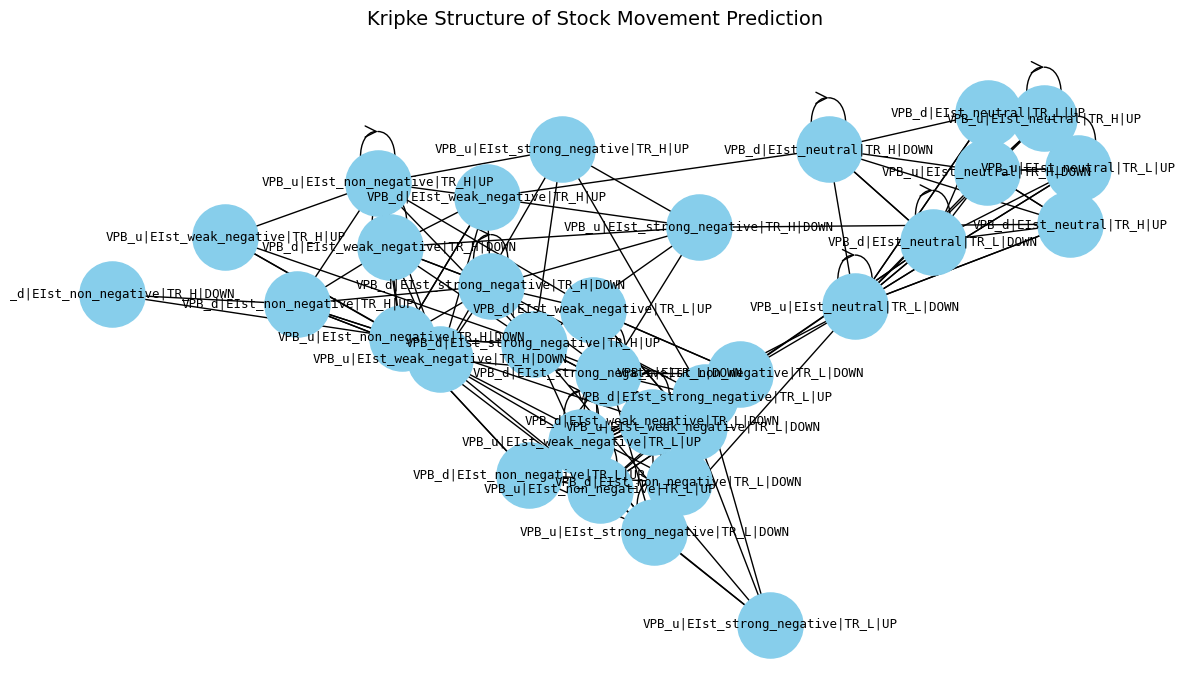

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


data = final_df[['VPB_dir', 'EIst_class', 'TR_Class', 'label']]

# ---- 1. Create state strings (unique combinations of features + label) ----
def create_state(row):
    return f"VPB_{row['VPB_dir'][0]}|EIst_{row['EIst_class']}|TR_{row['TR_Class'][0]}|{'UP' if row['label'] == 1 else 'DOWN'}"

data['State'] = data.apply(create_state, axis=1)

# Map to unique state IDs (avoid redundancy)
unique_states = data['State'].unique()
state_id_map = {state: f"s{i}" for i, state in enumerate(unique_states)}
data['StateID'] = data['State'].map(state_id_map)

# ---- 2. Create transitions between consecutive rows ----
transitions = []
for i in range(len(data) - 1):
    src = data.iloc[i]['StateID']
    dst = data.iloc[i + 1]['StateID']
    transitions.append((src, dst))

# ---- 3. Create Kripke graph ----
G = nx.DiGraph()
G.add_edges_from(transitions)

# Set full labels for nodes (Kripke states)
label_map = {state_id_map[state]: state for state in unique_states}
nx.set_node_attributes(G, label_map, name="label")

# ---- 4. Visualize ----
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 7))
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color='skyblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, labels=label_map, font_size=9, font_family='monospace')

plt.title("Kripke Structure of Stock Movement Prediction", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipython-input-22-2848366538.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['State'] = data.apply(create_state, axis=1)
/tmp/ipython-input-22-2848366538.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['StateID'] = data['State'].map(state_id_map)


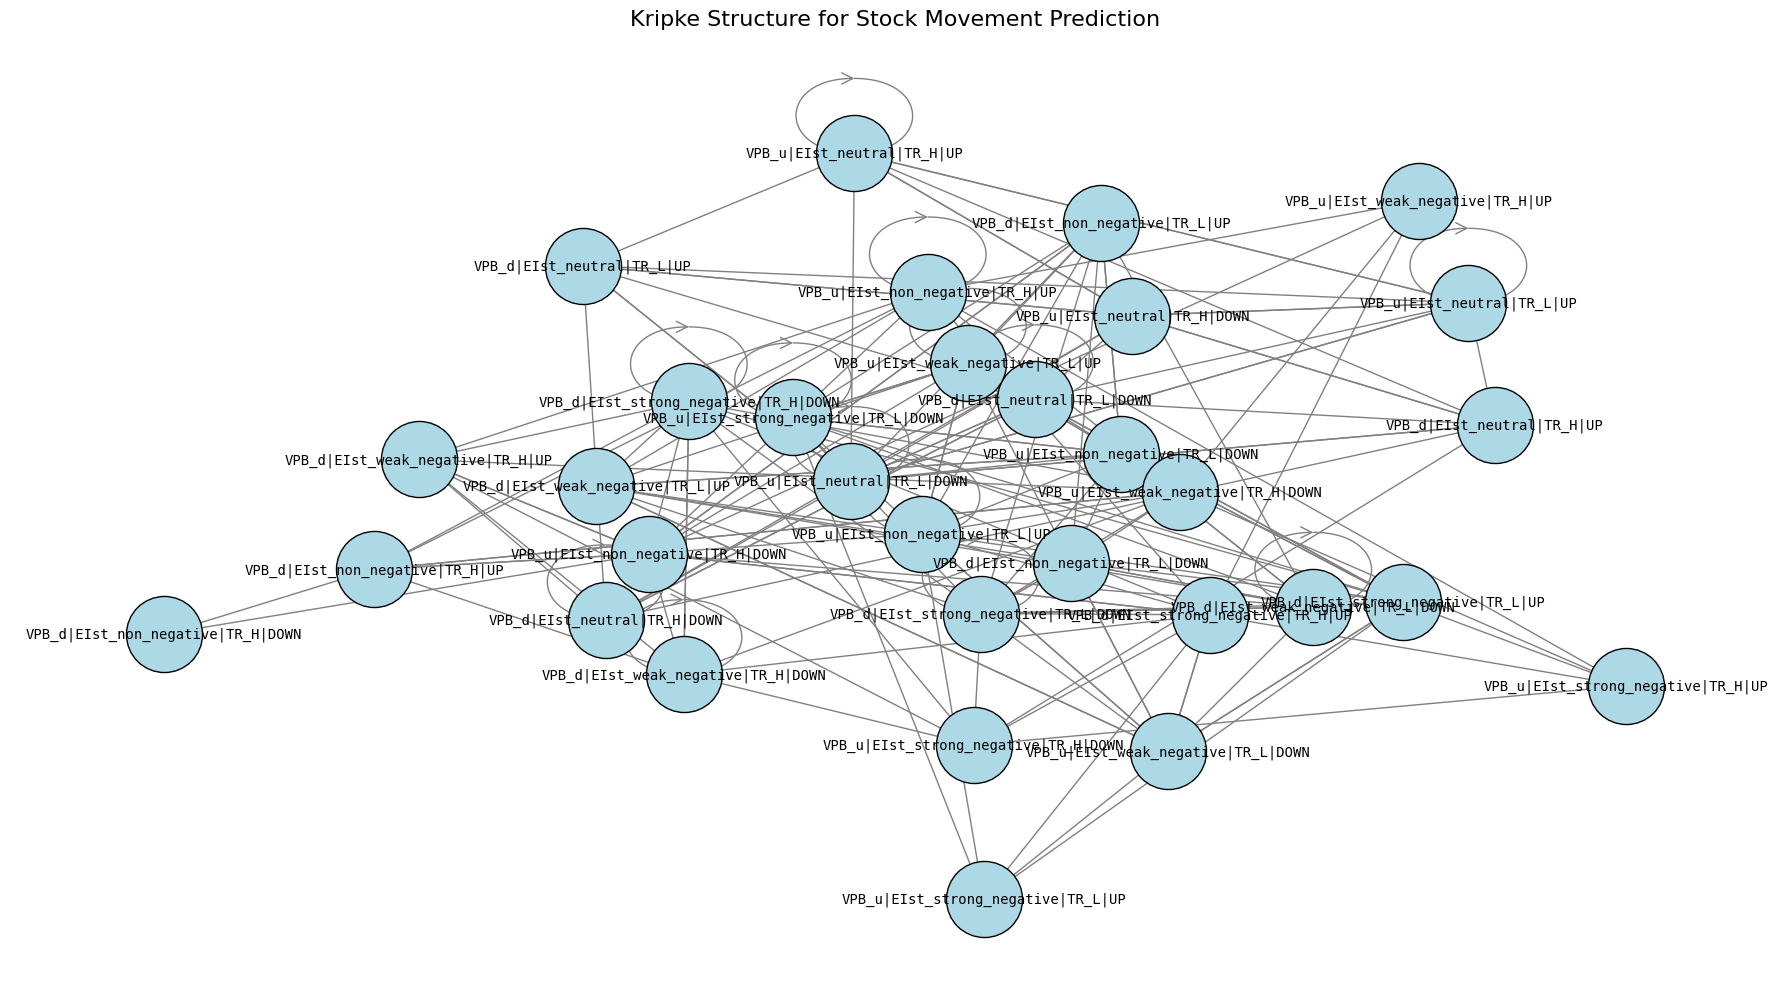

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ---- 1. Sample Data (replace with your real dataset) ----
data = final_df[['VPB_dir', 'EIst_class', 'TR_Class', 'label']]
# ---- 2. Create full state string from features + label ----
def create_state(row):
    label_str = 'UP' if row['label'] == 1 else 'DOWN'
    return f"VPB_{row['VPB_dir'][0]}|EIst_{row['EIst_class']}|TR_{row['TR_Class'][0]}|{label_str}"

data['State'] = data.apply(create_state, axis=1)

# ---- 3. Map each unique state to a short ID (s0, s1, ...) ----
unique_states = data['State'].unique()
state_id_map = {state: f"s{i}" for i, state in enumerate(unique_states)}
data['StateID'] = data['State'].map(state_id_map)

# ---- 4. Build transitions (edges between consecutive days) ----
transitions = []
for i in range(len(data) - 1):
    src = data.iloc[i]['StateID']
    dst = data.iloc[i + 1]['StateID']
    transitions.append((src, dst))

# ---- 5. Create networkx DiGraph ----
G = nx.DiGraph()
G.add_edges_from(transitions)

# Use full state label as node label
label_map = {state_id_map[state]: state for state in unique_states}
nx.set_node_attributes(G, label_map, name="label")

# ---- 6. Plot with larger figure and improved layout ----
plt.figure(figsize=(18, 10))  # Larger figure size for clarity
pos = nx.spring_layout(G, seed=42, k=1.2)  # More spread out

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=label_map, font_size=10, font_family='monospace')

plt.title("Kripke Structure for Stock Movement Prediction", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("kripke_structure.svg", format="svg")
plt.show()


In [ ]:
num_states = data['State'].nunique()
print(f"Number of unique states in the Kripke structure: {num_states}")


Number of unique states in the Kripke structure: 32


In [ ]:
!pip install sklearn-tree-rules


ERROR: Could not find a version that satisfies the requirement sklearn-tree-rules (from versions: none)
ERROR: No matching distribution found for sklearn-tree-rules


In [10]:
from sklearn.preprocessing import LabelEncoder

vpb_encoder = LabelEncoder().fit(['up', 'down'])
eist_encoder = LabelEncoder().fit(['neutral', 'non_negative', 'strong_negative', 'weak_negative'])
tr_encoder = LabelEncoder().fit(['high', 'low'])

print("VPB_dir:", list(vpb_encoder.classes_))
print("EIst_class:", list(eist_encoder.classes_))
print("TR_Class:", list(tr_encoder.classes_))


VPB_dir: [np.str_('down'), np.str_('up')]
EIst_class: [np.str_('neutral'), np.str_('non_negative'), np.str_('strong_negative'), np.str_('weak_negative')]
TR_Class: [np.str_('high'), np.str_('low')]


In [ ]:
from sklearn.tree import _tree

# Use your exact feature names from X.columns
# Example:
# X.columns = ['VPB_dir', 'EIst_class', 'FF_TR_Class', ...]

# Since you mentioned FF_TR_Class, replace 'TR_Class' with 'FF_TR_Class' in decoder map
vpb_encoder = ['down', 'up']
eist_encoder = ['neutral', 'non_negative', 'strong_negative', 'weak_negative']
ff_tr_encoder = ['low', 'high']
feature_decoders = {
    'VPB_dir': vpb_encoder,
    'EIst_class': eist_encoder,
    'FF_TR_Class': ff_tr_encoder
}


label_encoder = ['DOWN', 'UP']

def extract_rules_onehot(tree, feature_names, label_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # For binary features (one-hot), threshold is typically 0.5
            # Left child: feature <= 0.5 ‚Üí feature = 0 (category NOT present)
            # Right child: feature > 0.5 ‚Üí feature = 1 (category present)
            left_cond = f"{name} = 0"
            right_cond = f"{name} = 1"

            recurse(tree_.children_left[node], conditions + [left_cond])
            recurse(tree_.children_right[node], conditions + [right_cond])
        else:
            class_val = tree_.value[node].argmax()
            label = label_names[class_val]
            condition_str = " & ".join(conditions) if conditions else "True"
            ctl_formula = f"AG(({condition_str}) -> AX(label = {label}))"
            rules.append(ctl_formula)

    recurse(0, [])
    return rules

rules = extract_rules_onehot(rf.estimators_[0], list(X.columns), label_encoder)
for r in rules:
    print(r)


AG((FF_TR_Class = 0 & VPB_dir = 0 & EIst_class = 0) -> AX(label = DOWN))
AG((FF_TR_Class = 0 & VPB_dir = 0 & EIst_class = 1 & EIst_class = 0) -> AX(label = UP))
AG((FF_TR_Class = 0 & VPB_dir = 0 & EIst_class = 1 & EIst_class = 1 & EIst_class = 0) -> AX(label = UP))
AG((FF_TR_Class = 0 & VPB_dir = 0 & EIst_class = 1 & EIst_class = 1 & EIst_class = 1) -> AX(label = DOWN))
AG((FF_TR_Class = 0 & VPB_dir = 1 & EIst_class = 0 & EIst_class = 0) -> AX(label = UP))
AG((FF_TR_Class = 0 & VPB_dir = 1 & EIst_class = 0 & EIst_class = 1) -> AX(label = UP))
AG((FF_TR_Class = 0 & VPB_dir = 1 & EIst_class = 1) -> AX(label = DOWN))
AG((FF_TR_Class = 1 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 0) -> AX(label = DOWN))
AG((FF_TR_Class = 1 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 1 & EIst_class = 0) -> AX(label = DOWN))
AG((FF_TR_Class = 1 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 1 & EIst_class = 1) -> AX(label = DOWN))
AG((FF_TR_Class = 1 & EIst_class = 0 & VPB_dir = 1 & EIst_class = 0) -> AX

In [20]:
from sklearn.tree import _tree

def extract_rules_onehot_decoded(tree, feature_names, label_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            full_feature = feature_name[node]  # e.g. 'VPB_dir=up'
            if '=' in full_feature:
                feature, category = full_feature.split('=')
            else:
                feature, category = full_feature, None  # fallback

            # Left child means this category is NOT present (feature=0)
            left_cond = f"{feature} != {category}" if category else f"{full_feature} = 0"
            # Right child means this category is present (feature=1)
            right_cond = f"{feature} = {category}" if category else f"{full_feature} = 1"

            recurse(tree_.children_left[node], conditions + [left_cond])
            recurse(tree_.children_right[node], conditions + [right_cond])
        else:
            class_val = tree_.value[node].argmax()
            label = label_names[class_val]
            condition_str = " & ".join(conditions) if conditions else "True"
            ctl_formula = f"AG(({condition_str}) -> AX(label = {label}))"
            rules.append(ctl_formula)

    recurse(0, [])
    return rules


In [21]:
label_encoder = ['DOWN', 'UP']  # or your actual class labels

rules = extract_rules_onehot_decoded(rf.estimators_[0], list(X.columns), label_encoder)
for r in rules:
    print(r)

AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 0 & FF_TR_Class = 0) -> AX(label = DOWN))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 0 & FF_TR_Class = 1) -> AX(label = DOWN))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 1 & FF_TR_Class = 0) -> AX(label = UP))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 0 & EIst_class = 1 & FF_TR_Class = 1) -> AX(label = DOWN))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 1 & EIst_class = 0 & FF_TR_Class = 0) -> AX(label = UP))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 1 & EIst_class = 0 & FF_TR_Class = 1) -> AX(label = UP))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 1 & EIst_class = 1 & FF_TR_Class = 0) -> AX(label = UP))
AG((EIst_class = 0 & EIst_class = 0 & VPB_dir = 1 & EIst_class = 1 & FF_TR_Class = 1) -> AX(label = DOWN))
AG((EIst_class = 0 & EIst_class = 1 & VPB_dir = 0 & FF_TR_Class = 0) -> AX(label = DOWN))
AG((EIst_class = 0 & EIst_class = 1 & VPB_dir = 0 & FF_TR_Clas

In [26]:
from sklearn.tree import _tree

# Your label and feature encoders
vpb_encoder = ['down', 'up']
eist_encoder = ['neutral', 'non_negative', 'strong_negative', 'weak_negative']
ff_tr_encoder = ['low', 'high']

feature_decoders = {
    'VPB_dir': vpb_encoder,
    'EIst_class': eist_encoder,
    'FF_TR_Class': ff_tr_encoder
}

label_encoder = ['DOWN', 'UP']

def extract_rules_with_category_values(tree, feature_names, label_names, feature_decoders):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = feature_name[node]
            threshold = tree_.threshold[node]

            # Get decoded value if applicable
            if feature in feature_decoders:
                try:
                    index = int(threshold + 0.5)  # round threshold to get index
                    categories = feature_decoders[feature]
                    if 0 <= index < len(categories):
                        category = categories[index]
                    else:
                        category = f"[unknown-{index}]"
                except:
                    category = "[error]"
            else:
                category = f"{threshold:.2f}"

            # Left = feature <= threshold ‚Üí feature != category
            # Right = feature > threshold ‚Üí feature = category
            left_cond = f"{feature} != {category}"
            right_cond = f"{feature} = {category}"

            recurse(tree_.children_left[node], conditions + [left_cond])
            recurse(tree_.children_right[node], conditions + [right_cond])
        else:
            class_val = tree_.value[node].argmax()
            label = label_names[class_val]
            condition_str = " & ".join(conditions) if conditions else "True"
            ctl_formula = f"AG(({condition_str}) -> AX(label = {label}))"
            rules.append(ctl_formula)

    recurse(0, [])
    return rules

# Usage
feature_names = list(X.columns)  # your original features
rules = extract_rules_with_category_values(rf.estimators_[0], feature_names, label_encoder, feature_decoders)

for r in rules:
    print(r)


AG((VPB_dir != up & EIst_class != non_negative & FF_TR_Class != high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class != non_negative & FF_TR_Class = high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class != strong_negative & FF_TR_Class != high) -> AX(label = UP))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class != strong_negative & FF_TR_Class = high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class = strong_negative & EIst_class != weak_negative & FF_TR_Class != high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class = strong_negative & EIst_class != weak_negative & FF_TR_Class = high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class = strong_negative & EIst_class = weak_negative & FF_TR_Class != high) -> AX(label = DOWN))
AG((VPB_dir != up & EIst_class = non_negative & EIst_class = strong_negative & EIst_class = weak_negative & FF_TR_Class = high)

In [28]:
def generate_nusmv_model(data, transitions, ctl_specs, output_path='model.smv'):
    # 1. Collect all state IDs
    all_states = sorted(set(data['StateID']))

    # 2. Create transition dictionary
    transition_dict = {state: [] for state in all_states}
    for src, dst in transitions:
        transition_dict[src].append(dst)

    # 3. Start building NuSMV lines
    lines = []
    lines.append("MODULE main\n")
    lines.append("VAR\n")
    lines.append("  state : {" + ", ".join(all_states) + "};\n")
    lines.append("ASSIGN\n")
    lines.append("  init(state) := " + data.iloc[0]['StateID'] + ";\n")

    # 4. next(state) definition
    lines.append("  next(state) := case")
    for src in all_states:
        if transition_dict[src]:
            dsts = ", ".join(set(transition_dict[src]))
            # if multiple next states, make it a union
            if len(transition_dict[src]) > 1:
                dsts_list = ", ".join(f"{dst}" for dst in transition_dict[src])
                lines.append(f"    state = {src} : {{ {dsts_list} }};")
            else:
                lines.append(f"    state = {src} : {transition_dict[src][0]};")
    lines.append("    TRUE : state;")  # default: remain in same state
    lines.append("  esac;\n")

    # 5. Add SPECs for CTL formulas
    for spec in ctl_specs:
        lines.append(f"SPEC {spec}")

    # 6. Write to file
    with open(output_path, 'w') as f:
        f.write("\n".join(lines))
    
    print(f"NuSMV model saved to: {output_path}")


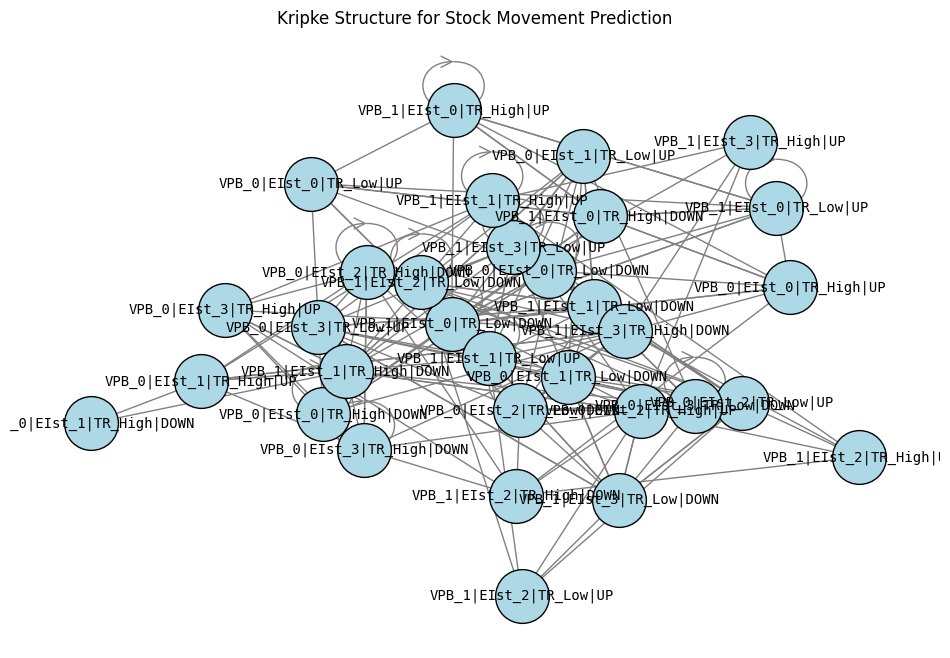

In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Example dummy dataset - replace with your real final_df
# final_df = pd.DataFrame({
#     'VPB_dir': ['up', 'down', 'up', 'down'],          # Make sure these are strings
#     'EIst_class': ['neutral', 'neutral', 'strong_negative', 'weak_negative'],
#     'TR_Class': ['high', 'low', 'high', 'low'],       # Make sure these are strings
#     'label': [1, 0, 1, 0]
# })

# Ensure columns are strings (important if your data has integers)
final_df['VPB_dir'] = final_df['VPB_dir'].astype(str)
final_df['TR_Class'] = final_df['TR_Class'].astype(str)

# Function to create a unique state string from features + label
def create_state(row):
    label_str = 'UP' if row['label'] == 1 else 'DOWN'
    return f"VPB_{row['VPB_dir']}|EIst_{row['EIst_class']}|TR_{row['TR_Class']}|{label_str}"

# Apply to create the 'State' column
final_df['State'] = final_df.apply(create_state, axis=1)

# Map each unique state to a short ID (s0, s1, ...)
unique_states = final_df['State'].unique()
state_id_map = {state: f"s{i}" for i, state in enumerate(unique_states)}
final_df['StateID'] = final_df['State'].map(state_id_map)

# Build transitions: edges between consecutive days/rows
transitions = []
for i in range(len(final_df) - 1):
    src = final_df.iloc[i]['StateID']
    dst = final_df.iloc[i + 1]['StateID']
    transitions.append((src, dst))

# Optional: build and plot the Kripke structure graph
G = nx.DiGraph()
G.add_edges_from(transitions)
label_map = {state_id_map[state]: state for state in unique_states}
nx.set_node_attributes(G, label_map, name="label")

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=1.2)
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=label_map, font_size=10, font_family='monospace')
plt.title("Kripke Structure for Stock Movement Prediction")
plt.axis('off')
plt.show()

# Now you have:
# - final_df with State and StateID columns
# - transitions as edges list

# You can proceed to call your NuSMV model generation function here
# generate_nusmv_model(final_df, transitions, ctl_specs, output_path='model.smv')


## Helper Function to Map Rule Conditions ‚Üí StateIDs

In [38]:
import re

def quote_string_literals(cond_str):
    """
    Replace patterns like
       VPB_dir = down
    with
       VPB_dir == 'down'
    Also converts '=' to '==' and adds quotes around RHS string literals.
    """
    # Replace '=' with '=='
    cond_str = cond_str.replace("=", "==")

    # Regex to find all == <word> where <word> is not a number or already quoted
    pattern = re.compile(r"==\s*([a-zA-Z_]+)")

    def replacer(match):
        val = match.group(1)
        # If val is not numeric and not already quoted, quote it
        if not val.isnumeric() and not (val.startswith("'") or val.startswith('"')):
            return f"== '{val}'"
        else:
            return f"== {val}"

    cond_str = pattern.sub(replacer, cond_str)
    
    # Replace '&' with 'and' for pandas query
    cond_str = cond_str.replace("&", "and")

    return cond_str


def match_states_by_condition(df, condition_str):
    """
    Given a condition string like 'VPB_dir = down & FF_TR_Class = low',
    return all matching StateIDs.
    """
    try:
        query_str = quote_string_literals(condition_str)
        matching_rows = df.query(query_str)
        return set(matching_rows['StateID'])
    except Exception as e:
        print(f"Failed to parse condition: {condition_str}")
        print(f"Error: {e}")
        return set()


In [63]:
def convert_feature_rule_to_state_ctl(df, rule):
    """
    Convert feature-based CTL formula:
        AG((VPB_dir = down & TR_Class = low) -> AX(label = DOWN))
    Into:
        AG(state in {s0, s2, ...} -> AX(state in {s1, s4, ...}))
    """
    rule = rule.replace("FF_TR_Class", "TR_Class")  # Or vice versa
    try:
        pre, post = rule.split("->")
        pre = pre.strip("AG( (").strip()
        post = post.strip(") )").replace("AX(", "").replace(")", "").strip()
        
        from_states = match_states_by_condition(df, pre)
        to_states = match_states_by_condition(df, post)
        
        if not from_states or not to_states:
            return None

        pre_str = " | ".join([f"state = {s}" for s in from_states])
        post_str = " | ".join([f"state = {s}" for s in to_states])
        return f"AG(({pre_str}) -> AX({post_str}))"
    except Exception as e:
        print(f"Failed to convert rule: {rule}")
        print(e)
        return None


In [40]:
def generate_nusmv_state_model(data, transitions, ctl_specs, output_path='model.smv'):
    state_ids = sorted(data['StateID'].unique())
    
    with open(output_path, 'w') as f:
        f.write("MODULE main\n")
        f.write("VAR\n")
        f.write("    state : {" + ", ".join(state_ids) + "};\n\n")
        
        f.write("ASSIGN\n")
        f.write(f"    init(state) := {state_ids[0]};\n")
        f.write("    next(state) := case\n")
        
        for src in state_ids:
            next_states = [dst for (s, dst) in transitions if s == src]
            if next_states:
                dst_set = ", ".join(set(next_states))
                if len(next_states) > 1:
                    f.write(f"        state = {src} : {{{dst_set}}};\n")
                else:
                    f.write(f"        state = {src} : {next_states[0]};\n")
        
        f.write("        TRUE : state;\n")
        f.write("    esac;\n\n")

        f.write("-- CTL Specifications\n")
        for spec in ctl_specs:
            f.write(f"SPEC {spec}\n")

    print(f"‚úÖ NuSMV model saved to: {output_path}")


In [61]:
# -- Load or build your dataset (final_df) and build State/StateID columns --
# def create_state(row):
#     label_str = 'UP' if row['label'] == 1 else 'DOWN'
#     return f"VPB_{str(row['VPB_dir'])}|EIst_{row['EIst_class']}|TR_{str(row['TR_Class'])}|{label_str}"

def create_state(row):
    label_str = 'UP' if row['label'] == 1 else 'DOWN'
    return f"VPB_{row['VPB_dir']}|EIst_{row['EIst_class']}|FFTR_{row['FF_TR_Class']}|{label_str}"

final_df['State'] = final_df.apply(create_state, axis=1)
unique_states = final_df['State'].unique()
state_id_map = {state: f"s{i}" for i, state in enumerate(unique_states)}
final_df['StateID'] = final_df['State'].map(state_id_map)

# -- Build transitions between rows (daily changes) --
transitions = []
for i in range(len(final_df) - 1):
    src = final_df.iloc[i]['StateID']
    dst = final_df.iloc[i + 1]['StateID']
    transitions.append((src, dst))

# -- Feature-based RF rule(s) you extracted --
rf_rules = [
    "VPB_dir = down & FF_TR_Class = low -> AX(label = DOWN)",
    "VPB_dir = up & EIst_class = neutral -> AX(label = UP)"
]

# -- Convert those rules to CTL formulas on states --
ctl_specs = []
for rule in rf_rules:
    ctl = convert_feature_rule_to_state_ctl(final_df, rule)
    if ctl:
        ctl_specs.append(ctl)

# -- Generate final model file --
generate_nusmv_state_model(final_df, transitions, ctl_specs, output_path="model.smv")


No states matched condition: VPB_dir = down & FF_TR_Class = low
No states matched condition: VPB_dir = up & EIst_class = neutral
‚úÖ NuSMV model saved to: model.smv


In [49]:
rf_rules = [
    "AG((VPB_dir != up & EIst_class != non_negative & FF_TR_Class != high) -> AX(label = DOWN))",
    "VPB_dir = up & EIst_class = neutral -> AX(label = UP)"
]

ctl_specs = []
for rule in rf_rules:
    ctl = convert_feature_rule_to_state_ctl(final_df, rule)
    if ctl:
        ctl_specs.append(f"SPEC {ctl}")

with open('model.smv', 'a') as f:
    # Add at the end of generate_nusmv_state_model()
    # f.write("-- CTL Specifications\n")
    for spec in ctl_specs:
        f.write(f"{spec}\n")



Failed to parse condition: VPB_dir != up & EIst_class != non_negative & FF_TR_Class != high)
Error: ('EOF in multi-line statement', (2, 0))


In [50]:

ctl_specs

[]

In [59]:
def quote_string_literals(expr):
    import re

    # Normalize spaces
    expr = expr.strip().replace("\n", " ").replace("\r", " ")

    # Replace & ‚Üí and, | ‚Üí or (for pandas query compatibility)
    expr = expr.replace("&", " and ").replace("|", " or ")

    # Replace `=` with `==`, but avoid affecting `!=`
    expr = re.sub(r'(?<![!<>=])=(?!=)', '==', expr)

    # Add quotes around unquoted string literals after == or !=
    def replacer(match):
        op, val = match.groups()
        if val.startswith("'") or val.startswith('"') or val.isnumeric():
            return f"{op}{val}"
        return f"{op}'{val}'"

    expr = re.sub(r"(==|!=)\s*([a-zA-Z_][a-zA-Z0-9_]*)", replacer, expr)

    return expr


def convert_feature_rule_to_state_ctl(df, rule_str):
    import re

    rule_str = rule_str.strip().replace("\n", " ").replace("\r", " ")

    if '->' not in rule_str:
        print(f"Invalid rule: {rule_str}")
        return None

    condition_part, conclusion_part = map(str.strip, rule_str.split('->'))

    label_match = re.search(r'label\s*=\s*(\w+)', conclusion_part)
    if not label_match:
        print(f"Could not parse label in conclusion: {conclusion_part}")
        return None

    target_label = label_match.group(1)

    # Convert condition to pandas-compatible expression
    try:
        condition_query = quote_string_literals(condition_part)
        matching_rows = df.query(condition_query)
        matching_states = set(matching_rows['StateID'])
    except Exception as e:
        print(f"Failed to parse condition: {condition_part}")
        print(f"Error: {e}")
        return None

    # Match transitions to desired label
    successors = []
    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]
        if current_row['StateID'] in matching_states and str(next_row['label']).upper() == target_label.upper():
            successors.append(next_row['StateID'])

    if not matching_states:
        print(f"No states matched condition: {condition_part}")
        return None
    if not successors:
        print("Matched rows:")
        print(matching_rows[['StateID', 'label']].head())
        print(f"No successors found with label {target_label} after matching states.")
        return None

    lhs = ' | '.join([f"state = {s}" for s in matching_states])
    rhs = ' | '.join([f"state = {s}" for s in successors])




    return f"AG(({lhs}) -> AX({rhs}))"


In [64]:
rule = "VPB_dir != up & EIst_class != non_negative & FF_TR_Class != high -> AX(label = Down)"
ctl = convert_feature_rule_to_state_ctl(final_df, rule)
print("CTL formula:", ctl)


CTL formula: None


In [62]:
print("DataFrame columns:", final_df.columns.tolist())
print("Rule features:", set(re.findall(r'(\w+) =', ' '.join(rf_rules))))

DataFrame columns: ['ticker', 'date', 'first', 'high', 'low', 'close', 'value', 'volume', 'openint', 'period', 'open', 'last', 'symbol', 'trading_date', 'num_neg', 'num_pos', 'total', 'weighted_score', 'EIst', 'VCP_dir', 'VOP_dir', 'daily_change', 'TR', 'TR_Class', 'TR_Simplified', 'PE', 'VPE_dir', 'PB', 'VPB_dir', 'Is_Stable', 'FF_TR', 'FF_TR_Class', 'label', 'EIst_class', 'State', 'StateID']
Rule features: {'EIst_class', 'VPB_dir', 'label', 'FF_TR_Class'}


In [81]:
import re
from sklearn.tree import _tree

# 1. Data Preparation
def create_state(row):
    """Create state string from features"""
    label_str = 'UP' if row['label'] == 1 else 'DOWN'
    return f"VPB_{row['VPB_dir']}|EIst_{row['EIst_class']}|FFTR_{row['FF_TR_Class']}|{label_str}"

# Create state mappings
final_df['State'] = final_df.apply(create_state, axis=1)
state_id_map = {state: f"s{i}" for i, state in enumerate(final_df['State'].unique())}
final_df['StateID'] = final_df['State'].map(state_id_map)

# 2. Transition System
transitions = [(final_df.iloc[i]['StateID'], final_df.iloc[i+1]['StateID']) 
              for i in range(len(final_df)-1)]

# 3. Rule Processing Utilities
# def quote_string_literals(cond_str):
#     """Convert conditions to pandas-query format"""
#     cond_str = cond_str.replace("=", "==")
#     cond_str = re.sub(r"==\s*([a-zA-Z_]+)", 
#                      lambda m: f"== '{m.group(1)}'" if not m.group(1).isnumeric() else f"== {m.group(1)}", 
#                      cond_str)
#     return cond_str.replace("&", "and")

# def match_states_by_condition(df, condition_str):
#     """Find states matching a condition"""
#     try:
#         query_str = quote_string_literals(condition_str.replace("FF_TR_Class", "FF_TR_Class"))
#         return set(df.query(query_str)['StateID'])
#     except Exception as e:
#         print(f"Error matching {condition_str}: {str(e)}")
#         return set()


def quote_string_literals(cond_str):
    # Replace only single '=' that are not already '=='
    cond_str = re.sub(r'(?<![=!])=(?!=)', '==', cond_str)
    cond_str = cond_str.replace("&", " and ")
    
    def replacer(match):
        var, val = match.groups()
        # Quote if val is not a number and not already quoted
        if val.replace('.', '', 1).isdigit():
            return f"{var} == {val}"
        if val.startswith("'") or val.startswith('"'):
            return f"{var} == {val}"
        return f"{var} == '{val}'"
    
    pattern = re.compile(r'(\w+)\s*==\s*([^\'"\s&|]+)')
    return pattern.sub(replacer, cond_str)




# def match_states_by_condition(df, condition_str):
#     """Find states matching a condition with robust error handling"""
#     try:
#         # Standardize feature names
#         condition_str = condition_str.replace("FF_TR_Class", "FF_TR_Class")
        
#         # Convert to pandas query format
#         query_str = quote_string_literals(condition_str)
#         print(f"Debug - Query: {query_str}")  # For troubleshooting
        
#         # Execute query
#         matching = df.query(query_str, engine='python')
#         return set(matching['StateID'])
#     except Exception as e:
#         print(f"Error processing condition: {condition_str}\n{str(e)}")
#         return set()


def match_states_by_condition(df, condition_str):
    try:
        query_str = quote_string_literals(condition_str)
        print(f"Debug - Query: {query_str}")
        matching = df.query(query_str, engine='python')
        return set(matching['StateID'])
    except Exception as e:
        print(f"Error processing condition: {condition_str}\n{str(e)}")
        return set()


# 4. Rule Conversion
def convert_feature_rule_to_state_ctl(df, rule):
    """Convert feature-based rule to state-based CTL"""
    try:
        # Handle both possible column names
        rule = rule.replace("FF_TR_Class", "FF_TR_Class")
        
        pre, post = rule.split("->")
        pre = pre.strip("AG( (").strip()
        post = post.strip(") )").replace("AX(", "").replace(")", "").strip()
        
        from_states = match_states_by_condition(df, pre)
        to_states = match_states_by_condition(df, post)
        
        if not from_states:
            print(f"No states match precondition: {pre}")
            return None
        if not to_states:
            print(f"No states match postcondition: {post}")
            return None

        pre_str = " | ".join([f"state = {s}" for s in from_states])
        post_str = " | ".join([f"state = {s}" for s in to_states])
        return f"AG(({pre_str}) -> AX({post_str}))"
    except Exception as e:
        print(f"Rule conversion failed: {str(e)}")
        return None

# 5. Model Generation
def generate_nusmv_state_model(data, transitions, ctl_specs, output_path='stock_model.smv'):
    """Generate complete NuSMV model file"""
    state_ids = sorted(data['StateID'].unique())
    
    with open(output_path, 'w') as f:
        # Write model header
        f.write("MODULE main\nVAR\n    state : {" + ", ".join(state_ids) + "};\n\n")
        
        # Write transition system
        # f.write("ASSIGN\n    init(state) := {state_ids[0]};\n")
        f.write(f"    init(state) := {state_ids[0]};\n")
        f.write("    next(state) := case\n")
        
        # Add all transitions
        transition_map = {}
        for src, dst in transitions:
            transition_map.setdefault(src, set()).add(dst)
            
        for src, dst_set in transition_map.items():
            dst_str = ", ".join(dst_set)
            f.write(f"        state = {src} : {{{dst_str}}};\n")
        
        f.write("        TRUE : state;\n    esac;\n\n")
        
        # Add CTL specifications
        if ctl_specs:
            f.write("-- CTL Specifications\n")
            for spec in ctl_specs:
                f.write(f"CTLSPEC {spec}\n")
        else:
            print("Warning: No CTL specifications added to model")

    print(f"NuSMV model successfully generated at {output_path}")
    print(f"States: {len(state_ids)}, Transitions: {len(transitions)}, CTL Specs: {len(ctl_specs)}")

# 6. Main Execution
if __name__ == "__main__":
    # Your Random Forest rules (example)
    rf_rules = [
        "VPB_dir == 'down' & FF_TR_Class == 'Low' -> AX(label == 'DOWN')",
        "VPB_dir == 'up' & EIst_class == 'neutral' -> AX(label == 'UP')"
    ]
    
    # Convert rules to CTL
    ctl_specs = []
    for rule in rf_rules:
        ctl = convert_feature_rule_to_state_ctl(final_df, rule)
        if ctl:
            print(f"Converted: {rule}\n  -> {ctl}")
            ctl_specs.append(ctl)
    
    # Generate the complete model
    generate_nusmv_state_model(final_df, transitions, ctl_specs)
    
    # Verify output
    with open('stock_model.smv') as f:
        print("\nGenerated model preview:")
        print(f.read()[:500] + "...")

Debug - Query: VPB_dir == 'down'  and  FF_TR_Class == 'Low'
Debug - Query: label == 'DOWN'
Converted: VPB_dir == 'down' & FF_TR_Class == 'Low' -> AX(label == 'DOWN')
  -> AG((state = s4 | state = s2 | state = s0 | state = s6) -> AX(state = s11 | state = s12 | state = s14 | state = s13 | state = s6 | state = s10 | state = s9 | state = s4 | state = s7 | state = s15 | state = s3 | state = s1 | state = s8 | state = s2 | state = s0 | state = s5))
Debug - Query: VPB_dir == 'up'  and  EIst_class == 'neutral'
Debug - Query: label == 'UP'
Converted: VPB_dir == 'up' & EIst_class == 'neutral' -> AX(label == 'UP')
  -> AG((state = s9 | state = s1) -> AX(state = s11 | state = s12 | state = s14 | state = s13 | state = s6 | state = s10 | state = s9 | state = s4 | state = s7 | state = s15 | state = s3 | state = s1 | state = s8 | state = s2 | state = s0 | state = s5))
NuSMV model successfully generated at stock_model.smv
States: 16, Transitions: 8767, CTL Specs: 2

Generated model preview:
MODULE main


In [76]:
final_df['label'] = final_df['label'].map({0: 'DOWN', 1: 'UP'})

In [77]:
print(final_df['VPB_dir'].unique())
print(final_df['FF_TR_Class'].unique())
print(final_df['EIst_class'].unique())
print(final_df['label'].unique())


['down' 'up']
['Low' 'High']
['neutral' 'non_negative' 'strong_negative' 'weak_negative']
['DOWN' 'UP']


In [82]:
import re
from sklearn.tree import _tree

# 1. Data Preparation
def create_state(row):
    """Create state string from features"""
    label_str = 'UP' if row['label'] == 1 else 'DOWN'
    return f"VPB_{row['VPB_dir']}|EIst_{row['EIst_class']}|FFTR_{row['FF_TR_Class']}|{label_str}"

# Create state mappings
final_df['State'] = final_df.apply(create_state, axis=1)
state_id_map = {state: f"s{i}" for i, state in enumerate(final_df['State'].unique())}
final_df['StateID'] = final_df['State'].map(state_id_map)

# 2. Transition System
transitions = [(final_df.iloc[i]['StateID'], final_df.iloc[i+1]['StateID']) 
              for i in range(len(final_df)-1)]

# 3. Rule Processing Utilities
# def quote_string_literals(cond_str):
#     """Convert conditions to pandas-query format"""
#     cond_str = cond_str.replace("=", "==")
#     cond_str = re.sub(r"==\s*([a-zA-Z_]+)", 
#                      lambda m: f"== '{m.group(1)}'" if not m.group(1).isnumeric() else f"== {m.group(1)}", 
#                      cond_str)
#     return cond_str.replace("&", "and")

# def match_states_by_condition(df, condition_str):
#     """Find states matching a condition"""
#     try:
#         query_str = quote_string_literals(condition_str.replace("FF_TR_Class", "FF_TR_Class"))
#         return set(df.query(query_str)['StateID'])
#     except Exception as e:
#         print(f"Error matching {condition_str}: {str(e)}")
#         return set()


def quote_string_literals(cond_str):
    # Replace only single '=' that are not already '=='
    cond_str = re.sub(r'(?<![=!])=(?!=)', '==', cond_str)
    cond_str = cond_str.replace("&", " and ")
    
    def replacer(match):
        var, val = match.groups()
        # Quote if val is not a number and not already quoted
        if val.replace('.', '', 1).isdigit():
            return f"{var} == {val}"
        if val.startswith("'") or val.startswith('"'):
            return f"{var} == {val}"
        return f"{var} == '{val}'"
    
    pattern = re.compile(r'(\w+)\s*==\s*([^\'"\s&|]+)')
    return pattern.sub(replacer, cond_str)




# def match_states_by_condition(df, condition_str):
#     """Find states matching a condition with robust error handling"""
#     try:
#         # Standardize feature names
#         condition_str = condition_str.replace("FF_TR_Class", "FF_TR_Class")
        
#         # Convert to pandas query format
#         query_str = quote_string_literals(condition_str)
#         print(f"Debug - Query: {query_str}")  # For troubleshooting
        
#         # Execute query
#         matching = df.query(query_str, engine='python')
#         return set(matching['StateID'])
#     except Exception as e:
#         print(f"Error processing condition: {condition_str}\n{str(e)}")
#         return set()


def match_states_by_condition(df, condition_str):
    try:
        query_str = quote_string_literals(condition_str)
        print(f"Debug - Query: {query_str}")
        matching = df.query(query_str, engine='python')
        return set(matching['StateID'])
    except Exception as e:
        print(f"Error processing condition: {condition_str}\n{str(e)}")
        return set()


# 4. Rule Conversion
def convert_feature_rule_to_state_ctl(df, rule):
    """Convert feature-based rule to state-based CTL"""
    try:
        # Handle both possible column names
        rule = rule.replace("FF_TR_Class", "FF_TR_Class")
        
        pre, post = rule.split("->")
        pre = pre.strip("AG( (").strip()
        post = post.strip(") )").replace("AX(", "").replace(")", "").strip()
        
        from_states = match_states_by_condition(df, pre)
        to_states = match_states_by_condition(df, post)
        
        if not from_states:
            print(f"No states match precondition: {pre}")
            return None
        if not to_states:
            print(f"No states match postcondition: {post}")
            return None

        pre_str = " | ".join([f"state = {s}" for s in from_states])
        post_str = " | ".join([f"state = {s}" for s in to_states])
        return f"AG(({pre_str}) -> AX({post_str}))"
    except Exception as e:
        print(f"Rule conversion failed: {str(e)}")
        return None

# 5. Model Generation
def generate_nusmv_state_model(data, transitions, ctl_specs, output_path='stock_model.smv'):
    """Generate complete NuSMV model file"""
    state_ids = sorted(data['StateID'].unique())
    
    with open(output_path, 'w') as f:
        # Write model header
        f.write("MODULE main\nVAR\n")
        f.write("    state : {" + ", ".join(state_ids) + "};\n\n")
        
        # Write ASSIGN block properly
        f.write("ASSIGN\n")
        # Initialize state to the first state in sorted list (single state, not set)
        f.write(f"    init(state) := {state_ids[0]};\n")
        
        # Write transitions
        f.write("    next(state) := case\n")
        
        # Build transition map
        transition_map = {}
        for src, dst in transitions:
            transition_map.setdefault(src, set()).add(dst)
        
        for src, dst_set in transition_map.items():
            dst_str = ", ".join(dst_set)
            f.write(f"        state = {src} : {{{dst_str}}};\n")
        
        f.write("        TRUE : state;\n")
        f.write("    esac;\n\n")
        
        # Add CTL specifications if any
        if ctl_specs:
            f.write("-- CTL Specifications\n")
            for spec in ctl_specs:
                f.write(f"CTLSPEC {spec}\n")
        else:
            print("Warning: No CTL specifications added to model")
    
    print(f"NuSMV model successfully generated at {output_path}")
    print(f"States: {len(state_ids)}, Transitions: {len(transitions)}, CTL Specs: {len(ctl_specs)}")


# 6. Main Execution
if __name__ == "__main__":
    # Your Random Forest rules (example)
    rf_rules = [
        "VPB_dir == 'down' & FF_TR_Class == 'Low' -> AX(label == 'DOWN')",
        "VPB_dir == 'up' & EIst_class == 'neutral' -> AX(label == 'UP')"
    ]
    
    # Convert rules to CTL
    ctl_specs = []
    for rule in rf_rules:
        ctl = convert_feature_rule_to_state_ctl(final_df, rule)
        if ctl:
            print(f"Converted: {rule}\n  -> {ctl}")
            ctl_specs.append(ctl)
    
    # Generate the complete model
    generate_nusmv_state_model(final_df, transitions, ctl_specs)
    
    # Verify output
    with open('stock_model.smv') as f:
        print("\nGenerated model preview:")
        print(f.read()[:500] + "...")

Debug - Query: VPB_dir == 'down'  and  FF_TR_Class == 'Low'
Debug - Query: label == 'DOWN'
Converted: VPB_dir == 'down' & FF_TR_Class == 'Low' -> AX(label == 'DOWN')
  -> AG((state = s4 | state = s2 | state = s0 | state = s6) -> AX(state = s11 | state = s12 | state = s14 | state = s13 | state = s6 | state = s10 | state = s9 | state = s4 | state = s7 | state = s15 | state = s3 | state = s1 | state = s8 | state = s2 | state = s0 | state = s5))
Debug - Query: VPB_dir == 'up'  and  EIst_class == 'neutral'
Debug - Query: label == 'UP'
Converted: VPB_dir == 'up' & EIst_class == 'neutral' -> AX(label == 'UP')
  -> AG((state = s9 | state = s1) -> AX(state = s11 | state = s12 | state = s14 | state = s13 | state = s6 | state = s10 | state = s9 | state = s4 | state = s7 | state = s15 | state = s3 | state = s1 | state = s8 | state = s2 | state = s0 | state = s5))
NuSMV model successfully generated at stock_model.smv
States: 16, Transitions: 8767, CTL Specs: 2

Generated model preview:
MODULE main


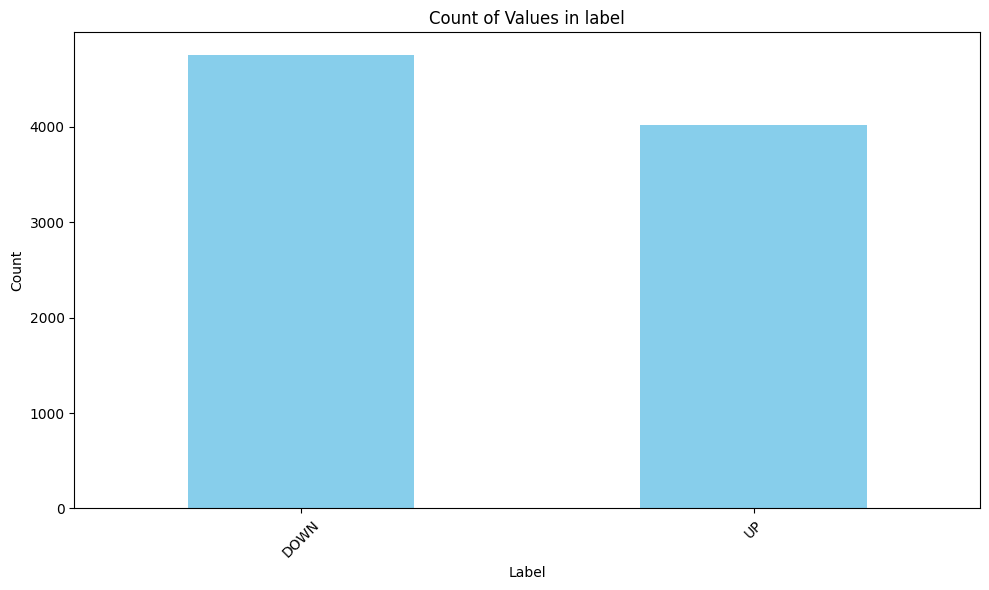

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate the DataFrames
final_df = pd.concat([shasta_final, mellat_final, foolad_final])
final_df['label'] = final_df['label'].map({0: 'DOWN', 1: 'UP'})

# Count values in the column of interest
value_counts = final_df['label'].value_counts()

# Plot the counts
value_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Count of Values in label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("k.svg", format="svg")
plt.show()


In [1]:
import pandas as pd

shasta_final = pd.read_csv('shasta_final.csv', encoding='utf-8')
mellat_final = pd.read_csv('mellat_final.csv', encoding='utf-8')
foolad_final = pd.read_csv('foolad_final.csv', encoding='utf-8')

final_df = pd.concat([shasta_final, mellat_final, foolad_final])
final_df.shape

(8768, 34)

In [5]:
final_df.columns

Index(['ticker', 'date', 'first', 'high', 'low', 'close', 'value', 'volume',
       'openint', 'period', 'open', 'last', 'symbol', 'trading_date',
       'num_neg', 'num_pos', 'total', 'weighted_score', 'EIst', 'VCP_dir',
       'VOP_dir', 'daily_change', 'TR', 'TR_Class', 'TR_Simplified', 'PE',
       'VPE_dir', 'PB', 'VPB_dir', 'Is_Stable', 'FF_TR', 'FF_TR_Class',
       'label', 'EIst_class'],
      dtype='object')

In [2]:
final_df.head()

ticker        date   first    high     low   close         value  \
0  Social Sec Inv  2020-04-13     0.0     0.0     0.0  1000.0  0.000000e+00   
1  Social Sec Inv  2020-04-14     0.0     0.0     0.0  1000.0  0.000000e+00   
2  Social Sec Inv  2020-04-15  8600.0  8600.0  8600.0  8600.0  5.761989e+13   
3  Social Sec Inv  2020-04-18  9030.0  9030.0  9030.0  8889.0  8.468741e+10   
4  Social Sec Inv  2020-04-19  9333.0  9333.0  9333.0  9027.0  4.054824e+10   

       volume  openint period  ...  TR_Simplified         PE VPE_dir  \
0           0        0      D  ...            NaN   6.211180    down   
1           0        0      D  ...            NaN   6.211180      up   
2  6699987426  2061657      D  ...            NaN  53.416149      up   
3     9378451     2122      D  ...            NaN  55.211180      up   
4     4344609     2796      D  ...            NaN  56.068323      up   

         PB  VPB_dir  Is_Stable     FF_TR  FF_TR_Class  label EIst_class  
0  0.228347     down      False  0.000000          Low      0    neutral  
1  0.228347       up      False  0.000000          Low      1    neutral  
2  1.963782       up       True  0.031502          Low      1    neutral  
3  2.029774       up      False  0.000044          Low      1    neutral  
4  2.061286       up      False  0.000020          Low      1    neutral  

[5 rows x 34 columns]

In [12]:
df = final_df

df['trading_date'] = pd.to_datetime(df['trading_date'], errors='coerce')

# Drop rows where date conversion failed (NaT)
df = df.dropna(subset=['trading_date'])

# Unique date count
unique_date_count = df['trading_date'].nunique()

# Start and end date
start_date = df['trading_date'].min()
end_date = df['trading_date'].max()

# Output results
print("Number of unique dates:", unique_date_count)
print("Start date:", start_date.date())
print("End date:", end_date.date())

Number of unique dates: 107
Start date: 2025-01-20
End date: 2025-07-12


In [14]:
import pandas as pd

# Convert both columns to datetime, coercing errors
df['trading_date'] = pd.to_datetime(df['trading_date'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Keep only rows where dates match
df_cleaned = df[df['trading_date'] == df['date']]

df_cleaned.head()

C:\Users\Partiran\AppData\Local\Temp\ipykernel_480\1320009007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trading_date'] = pd.to_datetime(df['trading_date'], errors='coerce')
C:\Users\Partiran\AppData\Local\Temp\ipykernel_480\1320009007.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


ticker       date   first    high     low   close         value  \
1149  Social Sec Inv 2025-01-20  1376.0  1385.0  1331.0  1344.0  9.760244e+11   
1150  Social Sec Inv 2025-01-21  1360.0  1383.0  1317.0  1354.0  4.384026e+11   
1151  Social Sec Inv 2025-01-22  1384.0  1394.0  1376.0  1394.0  7.431037e+11   
1152  Social Sec Inv 2025-01-25  1434.0  1434.0  1384.0  1411.0  6.130594e+11   
1153  Social Sec Inv 2025-01-26  1411.0  1420.0  1381.0  1394.0  5.701888e+11   

         volume  openint period  ...  TR_Simplified        PE VPE_dir  \
1149  726459126     9491      D  ...       0.684565  8.347826    down   
1150  323710805     6038      D  ...       0.308372  8.409938      up   
1151  533181715     6404      D  ...       0.508733  8.658385      up   
1152  434592585     6942      D  ...       0.418591  8.763975      up   
1153  408978854     6376      D  ...       0.393433  8.658385    down   

            PB  VPB_dir  Is_Stable     FF_TR  FF_TR_Class  label  \
1149  0.306898     down       True  0.003416          Low      1   
1150  0.309181       up       True  0.001522          Low      1   
1151  0.318315       up       True  0.002507          Low      1   
1152  0.322197       up       True  0.002043          Low      0   
1153  0.318315     down       True  0.001923          Low      0   

           EIst_class  
1149     non_negative  
1150     non_negative  
1151     non_negative  
1152     non_negative  
1153  strong_negative  

[5 rows x 34 columns]

In [15]:
df_cleaned.shape

(297, 34)

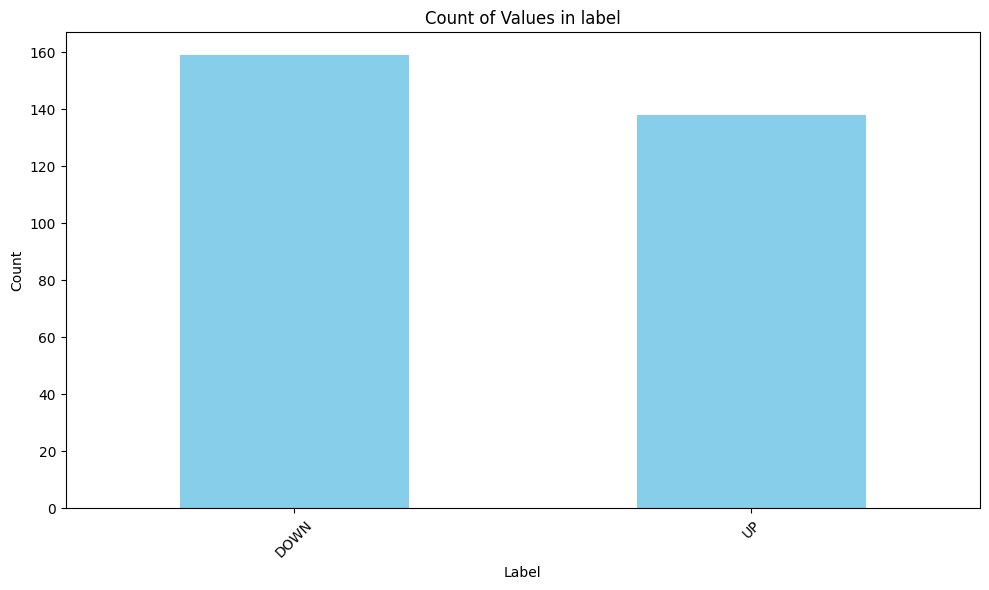

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate the DataFrames
df_cleaned['label'] = df_cleaned['label'].map({0: 'DOWN', 1: 'UP'})

# Count values in the column of interest
value_counts = df_cleaned['label'].value_counts()

# Plot the counts
value_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Count of Values in label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("k.svg", format="svg")
plt.show()
